# Introduction

This notebook walks through all the steps necessary to reproduce the analysis and the figures included in the main paper. The Supplementary Material, including all figures it includes, is compiled in its own document, `iceedge_supmat.ipynb`.

Please note that this study was the first one that I led which entirely used the Python data science universe (apart from some Matlab data files from a few collaborators). Hence a good deal of the following code can probably be optimized in terms of speed, especially the cartographic operations, both by using more advanced libraries (`shapely` and `geopandas` for spatial data; `datashader` for large plots; ...) and more economic calls to functions; the code also does a lot of pickling of python dict structures which probably could have been done more cleanly using `pandas` and/or shapefiles. This being said, all the code in this notebook does what it is supposed to and will give the reader an exact idea of what has been done to the data and how.

## Directory structure
The notebook operates mostly on three subdirectories:
- `nb_temp`, where intermediate files are stored so execution of the notebook can happen in several sessions,
- `nb_figures`, where figures go, and
- `nb_data`, where data files are exported for people to build on these findings.

## Environment
This notebook was run in a dedicated conda environment. The environment specifications are exported into a YAML file, e.g. for your own installation, for use in a [binder repository](https://mybinder.org), or with `repo2docker`, but [see this](https://repo2docker.readthedocs.io/en/latest/howto/export_environment.html#export-environment) for platform-specific issues.

In [ ]:
!conda env export --no-builds | grep -v "^prefix: " > binder/environment.yml

## First, load libraries, define custom functions and a map blueprint

In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib as mpl 
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.ticker as mticker

import netCDF4 as nc
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.io import loadmat
import gsw
from scipy import stats

def datetime2doy(datetime):
    doys = np.zeros_like(np.array(datetime))
    for k in range(len(doys)):
        y0=datetime[k].year
        datetime_startofyear=dt.datetime(year=y0, month=1, day=1)
        doys[k] = (datetime[k] - datetime_startofyear)/dt.timedelta(days=1)
    return doys
    
def hrssince2datetime(hrs,epoch):
    return epoch + dt.timedelta(hours=1) * hrs


import matplotlib.pyplot as plt
plt.close("all")

    
# Example of making your own norm.  Also see matplotlib.colors.
# From Joe Kington: This one gives two different linear ramps:    
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

What follows is a convenience function for laying out a basic map of the study area. What is computationally expensive is the call with `plotbathymetry=True` because it calculates bathymetry isolines on the fly (which ideally should just be precomputed to save time).

In [2]:
def map_blueprint (plotbathymetry=False,printmap=True,plotstations=False, 
                   fig=False,plotxlabels=True,plotylabels=True,
                   icecampmarker = True,
                   icecampmarkercolor='yellow',
                  label=0):
    '''returns: axes for cartopy plot,
    latlon2xy convenience function to convert latlon to chosen projection,
    and figure object'''
    if not printmap:
        plotbathymetry=False
        plotstations=False
    
    import matplotlib as mpl
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    import numpy as np
    import cartopy.feature as cfeature

    proj = ccrs.LambertConformal(central_longitude=-60, central_latitude=70,standard_parallels=(65,75))

    if fig==False:
        fig=plt.subplots()[0]
        ax = plt.axes(projection = proj)
    else:
        ax = fig.add_axes([.1,.1,.8,.8],projection = proj,label='axes{:d}'.format(label))
    hc=ax.coastlines(resolution='50m')

    MapExtent = [-66,-53,67,71.5]
    ax.set_extent(MapExtent, ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')

    gl.xlocator = mticker.FixedLocator([-75,-70,-65,-60,-55,-50,-45])
    gl.ylocator = mticker.FixedLocator([60,64,67,68,69,70,71,72,76])

    if plotxlabels:
        # LONGITUDE LABELS
        y0,_ = ax.get_ylim()
        for lon in [-65,-60,-55]:
            x0,_ = proj.transform_point(lon,MapExtent[2]-1,src_crs = ccrs.PlateCarree())
            plt.text(x0,y0-1e4,'{:2d}$^\circ$W'.format(-lon),horizontalalignment = 'center',verticalalignment='top')

    if plotylabels:
        # LATITUDE LABELS
        x0,_ = ax.get_xlim()
        someLons = np.arange(-90,-40,1)
        for lat in [68,69,70,71]:
            # interpolate latitude circle to map boundary
            xyzArray = proj.transform_points(ccrs.PlateCarree(),
                                        someLons,lat*np.ones_like(someLons))
            x = xyzArray[:,0]
            y = xyzArray[:,1]
            y0 = np.interp(x0,x,y)
            plt.text(x0-1e4,y0,'{:2d}$^\circ$N'.format(lat),horizontalalignment = 'right',verticalalignment='center')

    def latlon2xy(lon,lat):
        xyz = proj.transform_points(ccrs.PlateCarree(),lon,lat).squeeze()
        x,y,_ = np.split(xyz,3,axis=len(xyz.shape)-1)
        x[np.isinf(x)]=np.nan
        y[np.isinf(y)]=np.nan
        return x.squeeze(),y.squeeze()

    # ICE CAMP
    if icecampmarker:
        xIceCamp,yIceCamp = latlon2xy(np.array([-63.78953333]),np.array([67.47973333]))
        ax.plot(xIceCamp,yIceCamp,'*',markeredgecolor='k',markerfacecolor=icecampmarkercolor,markersize=15)
    
    # GE Stations
    if plotstations:
        ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data.pandas')
        ax.plot(*latlon2xy(np.array(ctd['Longitude']),np.array(ctd['Latitude'])),
                'o',markeredgecolor='k',markerfacecolor='white',markersize=6)

    if plotbathymetry:
        top = loadmat('data/IBCAO/IBCAO_1min_bathy.mat')
        lonMap,latMap=np.meshgrid(top['x'],top['y'])
        zMap=-top['IBCAO_1min']
        xMap,yMap = latlon2xy(lonMap,latMap)
        ax.contour(xMap,yMap,zMap,levels=[250,500],colors='gray',linewidths=1.5)
    
    if not printmap: plt.close(fig)
    
    return ax,latlon2xy,fig

# retrieve latlon conversion function
_,latlon2xy,_=map_blueprint(printmap=False)

# Sea Ice
Calculate sea ice-related variables. All based on AMSR2 on the 3.125-km Arctic grid.

## The ice edge position as a function of the day of the year

Steps:
1. Read lat/lon grid
2. Define masks to mask out land and near-costal (closer than 50 km from coast) data
3. Extract ice edge contours at 15% ice concentration

(This part is probably the clumsiest one of the notebook in terms of programming and efficiency.)

`!conda install -c conda-forge basemap-data-hires`

In [ ]:
datadir = 'data/AMSR2/'

# read in lat/lon grid
latlonFile = datadir+'LongitudeLatitudeGrid_3.125km_Arctic.nc'
latlonNetcdf = nc.Dataset(latlonFile)
lat = latlonNetcdf.variables['latitude'][:]
lon = latlonNetcdf.variables['longitude'][:]
maskLatlon = (lat>=67.5)&(lat<=71)&(lon>=-70)&(lon<=-50)

# mask out everything outside our region of interest
x=latlonNetcdf.variables['x'][:].squeeze()
y=latlonNetcdf.variables['y'][:].squeeze()
xMesh,yMesh = np.meshgrid(x,y)
xMin,xMax,yMin,yMax=xMesh[maskLatlon].min(),xMesh[maskLatlon].max(),yMesh[maskLatlon].min(),yMesh[maskLatlon].max()
maskX = (x>=xMin)&(x<=xMax)
maskY = (y>=yMin)&(y<=yMax)
maskXY = np.ix_(maskX,maskY)
lat=lat[maskXY]
lon=lon[maskXY]

del xMin,xMax,yMin,yMax,latlonFile,x,y

import mpl_toolkits.basemap as bm
m = bm.Basemap(width=2000e3,height=2000e3,
            resolution='i',projection='stere',
            lat_ts=70,lat_0=70,lon_0=-60.)

x,y = m(lon,lat)
fig, ax = plt.subplots()
coast = m.drawcoastlines()
plt.close(fig)
coastlines = np.vstack(coast.get_segments())
distanceToCoast = np.empty_like(x)
for index,_ in np.ndenumerate(x):
    distanceToCoast[index] = np.nanmin(np.sqrt(
            (coastlines[:,0]-x[index])**2+(coastlines[:,1]-y[index])**2))

# exclude land, points close to coast, 
# AND points on the other side of Baffin Island
maskCoast = distanceToCoast >=50e3 # distance in m   
maskLand = nc.Dataset(datadir+'Arc_20160301_res3.125_pyres.nc','r').variables['land'][:][maskXY]

maskLandAndCoast = maskLand & maskCoast & (x>=550e3)

# input: theContour.collections[i]
# output: Nx2 array of all vertices
def get_contour(contourCollection):
    paths = []
    # for each separate section of the contour line
    for pp in contourCollection.get_paths():
        xy = []
        for vv in pp.iter_segments():
            xy.append(vv[0])
        paths.append(np.vstack(xy))
    return np.vstack(paths)

# use equidistant y grid to average ice edge position
# in y coordinate 20 km bins
yGrid = np.arange(y.min(),y.max(),20e3)
def average_iceedge_yGrid(C):
    x,y=np.split(C,2,axis=1)
    averagedC = np.zeros([len(yGrid)-1,2])
    for k,_ in enumerate(yGrid[0:-1]):
        # find vertices falling into the current y bin
        maskY = (y>=yGrid[k]) & (y<=yGrid[k+1])
        # disregard vertices whose x coordinate deviates too much
        # from mean x inside a yDistStd=50km bin
        yDistStd = 50e3
        allxStdBin = x[(y<=yGrid[k]+yDistStd)&(y>=yGrid[k]-yDistStd)]
        x0   = np.nanmean(allxStdBin)
        xStd = np.nanstd(allxStdBin)
        maskX = (x<= x0 + xStd) & (x>= x0 - xStd)
        theMask = maskY & maskX
        averagedC[k] = np.nanmean(
                C[np.c_[theMask,theMask]].reshape([theMask.sum(),2]),axis=0)
    return averagedC

# Increase along-track resolution of the ice edge
ContourInterpolatedDistance=np.arange(0,1.5e6,1e3) # same for all contours    
def interpolate_alongtrack (C): # input: contour C as supplied by contour plots
    # new, interpolated outline
    ContourInterpolated = np.zeros((len(ContourInterpolatedDistance),2))
    
    DistanceBetweenEachOriginalPoint = np.sqrt(np.diff(C[:,0])**2 + 
                    np.diff(C[:,1])**2)
    ContourOriginalDistance = np.r_[0,np.cumsum(
            np.where(np.isnan(DistanceBetweenEachOriginalPoint),
                     0,
                     DistanceBetweenEachOriginalPoint))]
            
    for i in range(0,2):
        ContourInterpolated[:,i] = np.interp(ContourInterpolatedDistance,
                            ContourOriginalDistance,C[:,i])
        ContourInterpolated[:,i][ContourOriginalDistance.max() 
            < ContourInterpolatedDistance] = np.nan
    return ContourInterpolated

allDoys = np.arange(120,196) # over which days of the year to loop
# initialize dictionaries for output
allContoursLatlon = {} # in lat/lon coordinates
allContours = {} # in map projection coordinates

for thisDoy in allDoys:
    thisDate = dt.datetime(2016,1,1)+dt.timedelta(days=int(thisDoy-1))
    filename = 'Arc_{:04d}{:02d}{:02d}_res3.125_pyres.nc'.format(thisDate.year,thisDate.month,thisDate.day)
    theNetcdf = nc.Dataset(datadir+filename,'r')
    iceConc = np.where(maskLandAndCoast,
                       theNetcdf.variables['sea_ice_concentration'][:].squeeze()[maskXY],
                       np.nan)
    # extract contour
    fig,ax=plt.subplots()
    theContours = plt.contour(x,y,iceConc,levels=[.15],colors='r')
    plt.close(fig)
    C = get_contour(theContours.collections[0])
    C = average_iceedge_yGrid(C)
    C = interpolate_alongtrack(C)
    CLatlon = np.where(np.isnan(C),
                 np.nan,
                 np.stack(m(C[:,0],C[:,1],inverse=True)).transpose())
    allContoursLatlon[thisDoy] = CLatlon
    allContours[thisDoy] = C

np.save('nb_temp/GE2016_Amundsen_iceedge_contours.npy',allContours)
np.save('nb_temp/GE2016_Amundsen_iceedge_contours_latlon.npy',allContoursLatlon)

### Calculate distances between each daily contour.

In [ ]:
allContours = np.load('nb_temp/GE2016_Amundsen_iceedge_contours.npy').item()
allDoys = np.array(list(allContoursLatlon.keys()))
# calculate distance from one contour to another
def get_contour_distance (C1,C2):
    distancesToOtherContour = np.zeros_like(C1)
    for index,(thisX,thisY) in enumerate(C1):
        distancesToOtherContour[index] = np.nanmin(np.sqrt(
            (C2[:,0]-thisX)**2+(C2[:,1]-thisY)**2))
    return distancesToOtherContour

distance = {}
direction = {}
for thisDoy in allDoys[1:-1]:
    distanceBack = get_contour_distance(allContours[thisDoy-1],  allContours[thisDoy])
    distanceForw = get_contour_distance(allContours[thisDoy],allContours[thisDoy+1])
    distance[thisDoy] = np.nanmean([np.nanmean(distanceBack),
            np.nanmean(distanceForw)])
    eastingYesterday = np.nanmean(allContours[thisDoy-1][:,0])
    eastingToday = np.nanmean(allContours[thisDoy][:,0])
    eastingTomorrow = np.nanmean(allContours[thisDoy+1][:,0])
    direction[thisDoy] = (eastingTomorrow-eastingYesterday)/2
    
    
import pandas as pd
pd.DataFrame(data={'direction': np.array(list(direction.values())),
                   'speed': np.array(list(distance.values()))},
             index= np.array(list(distance.keys()))).to_pickle(
    'nb_temp/GE2016_Amundsen_iceedge_speed.pandas')

np.save('nb_temp/GE2016_Amundsen_iceedge_speed.npy',distance)
np.save('nb_temp/GE2016_Amundsen_iceedge_direction.npy',direction) # positive=westward

## Open water days since / ice days until ice retreat

Map each point on the map to their distance from the ice edge. West of ice edge = negative distance

In [5]:
_,latlon2xy,_ = map_blueprint(False,False)

datadir = 'data/AMSR2/'
# ice lon/lat grid
latlonFile = datadir + 'LongitudeLatitudeGrid_3.125km_Arctic.nc'
latlonNetcdf = nc.Dataset(latlonFile)
latIce = latlonNetcdf.variables['latitude'][:]
lonIce = latlonNetcdf.variables['longitude'][:]
maskLatLon = (latIce>=67.5)&(latIce<=71)&(lonIce>=-70)&(lonIce<=-50)
latIce=latIce[maskLatLon]
lonIce=lonIce[maskLatLon]
xIce,yIce=latlon2xy(lonIce,latIce)

# load ice edge
edge = np.load('nb_temp/GE2016_Amundsen_iceedge_contours_latlon.npy').item()

allDoys = np.arange(120,213) # over which days of the year to loop

iceConc = np.nan*np.ones((xIce.shape[0],len(allDoys)))
distance = np.nan*np.ones((xIce.shape[0],len(allDoys)))
for k,thisDoy in enumerate(allDoys):
    thisDate = dt.datetime(2016,1,1)+dt.timedelta(days=int(thisDoy-1))    
    filenameIce = 'Arc_{:04d}{:02d}{:02d}_res3.125_pyres.nc'.format(thisDate.year,thisDate.month,thisDate.day)
    iceConc_toclean = nc.Dataset(datadir+filenameIce,'r').variables['sea_ice_concentration'][:].squeeze()[:][maskLatLon]
    iceConc_toclean[iceConc_toclean>150] = np.nan
    iceConc[:,k] = iceConc_toclean
    
    if thisDoy<196: # ice edge contours only computed for duration of campaign
        x,y=latlon2xy(edge[thisDoy][:,0],edge[thisDoy][:,1])
        for index,_ in np.ndenumerate(xIce):
            dist = np.sqrt((x-xIce[index])**2+(y-yIce[index])**2)
            i = np.nanargmin(dist)
            distance[index][k] = np.where(x[i] < xIce[index],
                                          dist[i],
                                          -dist[i])
    

ice = xr.Dataset({'iceConc': (['loc', 'doy'],  iceConc),
            'openwaterDaysSince': (['loc', 'doy'],  np.nancumsum(iceConc<15,axis=1)),
            'iceDaysUntil': (['loc', 'doy'],  np.nancumsum(iceConc[:,::-1]>15,axis=1)[:,::-1]),
            'distanceFromIceEdge_km': (['loc', 'doy'],  distance/1e3),
            
           },
            coords={'lon': (['loc'], lonIce),
                    'lat': (['loc'], latIce),
                    'doy': allDoys})
ice.to_netcdf('nb_temp/GE2016_openwaterdays.nc')
ice.to_dataframe().to_pickle('nb_temp/GE2016_openwaterdays.pandas')

## What causes ice edge retreat? - Time series of environmental forcing

Let us look at a time series plot of
1. Ice edge retreat speed,
2. Wind speed and direction, and
3. downwelling solar radiation.

Distances between each daily contour were already calculated above.

### Wind

This is based on the CCMP Wind Analysis product. First calculate the study area-mean wind for each doy.

In [6]:
datadir = 'data/CCMP/'

allDoys = np.arange(150,191)
meanwind={}

# read out general structure using any one file
theNetcdf = nc.Dataset(datadir+'M05/CCMP_Wind_Analysis_20160501_V02.0_L3.0_RSS.nc','r')
lat=theNetcdf.variables['latitude'][:]
lon=theNetcdf.variables['longitude'][:]
lon,lat=np.meshgrid(lon,lat)
#%%
for thisDoy in allDoys:
    #thisDoy=165
    thisDate = dt.datetime(2016,1,1)+dt.timedelta(days=int(thisDoy)-1)
    filename = 'M{:02d}/CCMP_Wind_Analysis_{:04d}{:02d}{:02d}_V02.0_L3.0_RSS.nc'.format(
            thisDate.month,thisDate.year,thisDate.month,thisDate.day)
    theNetcdf = nc.Dataset(datadir+filename,'r')
    u=theNetcdf.variables['uwnd'][:].mean(axis=0)
    v=theNetcdf.variables['vwnd'][:].mean(axis=0)
    
    mask = (lon>=360-62)&(lon<=360-57)&(lat>=68)&(lat<=71)
    U=np.nanmean(u[mask])
    V=np.nanmean(v[mask])
    meanwind[thisDoy] = np.array([U,V])

np.save('nb_temp/GE2016_Amundsen_meanwind.npy',meanwind)

### Area-mean downwelling solar radiation for each day.

To download the ERA-Interim reanalysis product using batch scripts, one can communicate with the servers by using a Python library provided by the ECMWF, shown in [this script](data/retrieve-netcdf_2016amundsen.py).

In [7]:
import netCDF4 as nc
import datetime as dt

d=nc.Dataset('data/GE2016_Amundsen_solarheatflux.nc')


# convert netcdf time to datetime to doy2016
# then take only every other timestamp to reduce data
t=datetime2doy(
        hrssince2datetime(d.variables['time'][:],
                         dt.datetime(1900,1,1)))[1::2]

# average over lon/lat
SW = d.variables['ssrd'][:].mean(axis=(1,2))
# sum each day (every two time steps)
SW = SW.reshape(int(len(SW)/2),2).mean(axis=1)

np.savez('nb_temp/GE2016_Amundsen_solarheatflux_mean.npz',doy=t,SW=SW)

### Finally, plot time series...


Average ice edge movement: 8.339009742834186km/day
Average ice retreat speed: 3.5528851842841958km


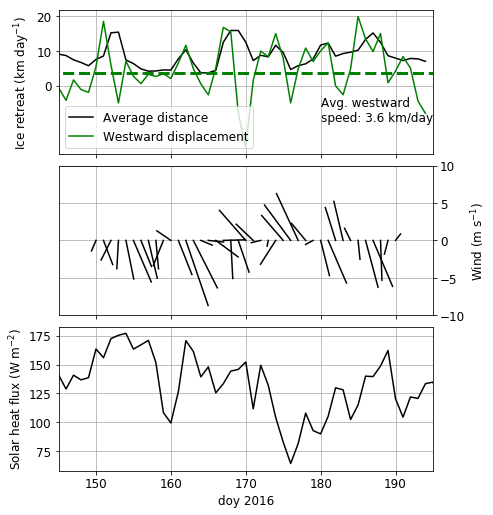

In [8]:
mpl.rc('font', **{'size' : 12})

SW=np.load('nb_temp/GE2016_Amundsen_solarheatflux_mean.npz')
t=SW['doy']
SW=SW['SW']

direction = np.load('nb_temp/GE2016_Amundsen_iceedge_direction.npy').item()

speed = np.load('nb_temp/GE2016_Amundsen_iceedge_speed.npy').item()

wind = np.load('nb_temp/GE2016_Amundsen_meanwind.npy').item()

winddoy = np.array(list(wind.keys()))
wind = np.array(list(wind.values()))

speeddoy = np.array(list(speed.keys()))
speed = np.array(list(speed.values()))
direction = np.array(list(direction.values()))

fig,axs=plt.subplots(3,1,sharex=True,figsize=(8,8))

ax=axs[0]
ax.plot(speeddoy,speed/1e3,'k-')
ax.plot(speeddoy,-direction/1e3,'g-')
ax.legend(['Average distance','Westward displacement'])
ax.set_ylabel('Ice retreat (km day$^{-1}$)')
ax.set_yticks([-20,0,10,20]) 
spd=np.nanmean(-direction/1e3)

ax=axs[1]
for i in range(len(winddoy)):
    x0=winddoy[i]
    y0=0
    dx,dy=wind[i]
    axs[1].plot([x0,x0+dx],[y0,y0+dy],'k')
ax.set_ylim(-10,10)
ax.set_aspect('equal', 'datalim')
ax.set_ylabel('Wind (m s$^{-1}$)')

ax=axs[2]
ax.plot(t,SW/86400,'k')
ax.set_xlim(145,195)
ax.set_xlabel('doy 2016')
ax.set_ylabel('Solar heat flux (W m$^{-2}$)')
ax.grid()

for i in range(2):
    axs[i].grid()    
axs[1].yaxis.set_label_position('right')
axs[1].yaxis.set_ticks_position('right')


axs[0].plot([100,200],[spd,spd],'--',color='green',lw=3)
axs[0].text(180,-7,'Avg. westward\nspeed: {:1.1f} km/day'.format(spd),
          verticalalignment='center',color='k')

axs[0].set_position([0.12,0.7  ,0.65,.25])
axs[1].set_position([0.12,0.42 ,0.65,.26])
axs[2].set_position([0.12,0.15  ,0.65,.25])


print('Average ice edge movement: {}km/day'.format(np.nanmean(speed/1e3)))
print('Average ice retreat speed: {}km'.format(np.nanmean(-direction/1e3)))
    
plt.savefig('nb_figures/FIGURE_4.pdf')

df = pd.DataFrame(dict(doy=speeddoy, Average_Distance=speed, Westward_Displacement=-direction))
df.to_csv('nb_data/FIGURE_4a.csv', index=False)

df = pd.DataFrame({'doy':winddoy, 'east_wind_ms-1':wind[:,0], 'north_wind_ms-1':wind[:,1]})
df.to_csv('nb_data/FIGURE_4b.csv', index=False)

df = pd.DataFrame({'doy':t, 'Solar_heat_flux_Wm-2':SW/86400})
df.to_csv('nb_data/FIGURE_4c.csv', index=False)

# Turbulence and vertical mixing

Based on SCAMP profiles.

In [ ]:
mat = loadmat('data/scamp/data_amundsen.mat')

# --- convert datenum
import datetime as dt
def matlab2datetime(datenum):
    if np.isnan(datenum):
        return np.nan
    else:
        day = dt.datetime.fromordinal(int(datenum))
        dayfrac = dt.timedelta(days=datenum%1) - dt.timedelta(days = 366)
        return day + dayfrac
    
# --- scamp data
scamp = xr.Dataset(coords={'time': (['Cast'], mat['time'].squeeze()),
                           'latitude': (['Cast'], mat['latitude'].squeeze()),
                           'longitude': (['Cast'], mat['longitude'].squeeze()),
                           'Depth': mat['depth'].squeeze(),
                           'Cast': np.arange(1,95)
                          })
for var in ['epsilon_cl','Kz', 'conductivity', 'temperature']:
     scamp[var] = (['Cast','Depth'], mat[var])
        
#
scampCtd = xr.Dataset(coords={'time': (['Set'], mat['DATE'].squeeze()),
                           'latitude': (['Set'], mat['LAT'].squeeze()),
                           'longitude': (['Set'], mat['LONG'].squeeze()),
                           'Depth': mat['depth'].squeeze(),
                           'Set': np.arange(25)
                          })
for var in ['pressure_ctd','salinity_ctd','temperature_ctd', 'density_ctd', 'NO3', 'N2_ctd']:
     scampCtd[var] = (['Set','Depth'], mat[var])
   

# --- load logbook
log1 = pd.read_excel('data/scamp/SCAMPLogBook_GreenEdge2016.xls',sheet_name='Leg1a'
                    ).set_index('STATION').transpose()[
    ['date (TU)','LAT','LONG','Vitesse vent']]
log2 = pd.read_excel('data/scamp/SCAMPLogBook_GreenEdge2016.xls',sheet_name='Leg1b'
                    ).set_index('STATION').transpose()[
    ['date (TU)','LAT','LONG','Vitesse vent']].drop('Ice camp/cycle')

log = pd.concat([log1,log2]).rename_axis(
    '', axis='columns').rename_axis('Station').reset_index()
log['Station'] = log['Station'].apply(lambda s: float(s[1:]))
log=log.rename_axis('Set').reset_index()

# --- Depth binning
# scamp
scamp=scamp.to_dataframe().reset_index()
scamp['epsilon_cl'].loc[scamp['epsilon_cl']>2e-7] = np.nan  
scamp['Depth']=pd.to_numeric(pd.cut(scamp['Depth'],np.arange(0,100,4),labels=np.arange(2,98.,4)))
scamp=scamp.groupby(['Cast','Depth']).median().reset_index()

# CTD-derived data
def sortvalues(dens, axis=0):
    return np.sort(dens)
scampCtd['density_sorted'] = scampCtd.density_ctd.reduce(sortvalues, dim='Depth')
scampCtd['N2_sorted'] = 9.81/(1e3+scampCtd.density_sorted.mean()) * scampCtd.density_sorted.diff(dim='Depth').interp_like(scampCtd)

scampCtd = scampCtd.to_dataframe().reset_index()
scampCtd['Depth']=pd.to_numeric(pd.cut(scampCtd['Depth'],np.arange(0,100,4),labels=np.arange(2,98.,4)))
scampCtd=scampCtd.groupby(['Set','Depth']).mean().reset_index()

# --- Sets
# binning into Sets uses the fact that there was
# max. 1 set per day and matlab datenum format counts days
bins = np.arange(np.floor(scamp['time'].min()),np.ceil(scamp['time'].max()+1))
scamp['Set'] = pd.cut(scamp['time'],
                      bins=bins,
                      labels = bins[:-1])

scamp=scamp.groupby(['Set','Depth']).mean().reset_index().dropna()#.drop('Cast')

sets = scamp['Set'].unique()
scamp['Set'] = np.interp(scamp['Set'], sets, np.arange(len(sets))).astype(int)
scamp['time'] = [matlab2datetime(tval) for tval in scamp['time']]

scamp=scamp.merge(log).set_index('Set')

scamp = scamp.merge(scampCtd[[
    'Set',
    'Depth',
    'pressure_ctd',
    'salinity_ctd',
    'temperature_ctd', 
    'density_ctd',
    'NO3', 
    'N2_ctd',
    'N2_sorted'
]], on=['Set', 'Depth'], how='outer')

# --- mixing layer depth h_eps
def find_heps(eps,depth):
    index = np.where((eps.values<5e-9) & (depth>5))[0]
    if len(index)>0:
        return depth.iloc[index[0]],eps.iloc[index[0]] # increase by 1 because of zero-based indexing
    else:
        return np.nan,np.nan
    
scamp = scamp.merge(pd.DataFrame(scamp.groupby('Set').apply(
    lambda row: find_heps(row['epsilon_cl'],row['Depth'])[0]),
                        columns={'heps'}),
            on='Set')

scamp = scamp.merge(pd.DataFrame(scamp.groupby('Set').apply(
    lambda row: find_heps(row['epsilon_cl'],row['Depth'])[1]),
                        columns={'eps_heps'}),
            on='Set')
    

# replace Bouffard+Boegman 2013 by Osborn 1980, as per recommendation by Gregg et al., 2018
scamp['Kz'] = 0.2 * scamp['epsilon_cl'] / scamp['N2_sorted']


# --- surface layer Kz
def find_Kz_sfc(Kz,depth):
    return Kz.loc[(depth<=20) & (depth>=5)].mean()
    
scamp = scamp.merge(pd.DataFrame(scamp.groupby('Set').apply(
    lambda row: find_Kz_sfc(row['Kz'],row['Depth'])),
                        columns={'Kz_avg'}),
            on='Set')

scamp.to_pickle('nb_temp/GE2016_scamp_setAverage.pandas')

# Assemble hydrography and combine with all other data

## Load and treat hydrography data

- First, read logfile.
- Then we have to read in hydrography and put it into a pandas dataframe, as they are shipped as an Ocean Data View spreadsheet (which I converted to netcdf).
- Average vertical profiles by station in 1-m bins
- Save hydrographic data into pandas dataframe, and pickle

In [10]:
log=pd.read_excel('data/hydrography/LogBook_1601.xls', skiprows=[0,1,2]
             )[['Cast','Station','Prof. cast (m)','Type']].iloc[2:]

def stn2float (s):
    if (s[0] == 'G') & (len(s)>1):
        return float(s[1:])
    else:
        return np.nan

log['Station'] = log['Station'].apply(stn2float)
log['transect'] = np.floor_divide(log['Station'],100)

log.to_csv('nb_temp/ctd-logfile.csv')

x = xr.open_dataset('data/hydrography/1601_ODV.nc')
x = x.rename({v: x[v].long_name for v in x if hasattr(x[v], 'long_name')})

x['Cast'] = x['Station'].astype('int')
ctd=x.to_dataframe().drop(columns=['Station'])

ctd = ctd.merge(log,on='Cast',how='outer')

ddoy = pd.Index(ctd['Decimal Gregorian Days of the station'])
ctd['doy'] = ddoy.dayofyear.values
ctd['hour'] = ddoy.hour.values

ctd=ctd.dropna(subset=['Asal'],how='any')
ctd.to_pickle('nb_temp/GE2016_Amundsen_hydrography_data_allcasts.pandas')

ctd['Depth']=pd.to_numeric(pd.cut(ctd['Depth'],np.arange(0.5,1001),labels=np.arange(1,1001)))
ctd = ctd.groupby(['Station','Depth']).mean().reset_index()

ctd['FRET_01'] = gsw.CT_freezing(ctd['Asal'],ctd['PRES_01'],saturation_fraction=1)

ctd.to_pickle('nb_temp/GE2016_Amundsen_hydrography_data.pandas')

## Combine hydrographic and nutrient data

Now we load the nutrient concentrations found in the rosette bottle samples and merge them into the same pandas dataframe.

For N$^\ast$, we take the definition of: Gruber, N. & Sarmiento, J. L. Global patterns of marine nitrogen fixation and denitrification. Global Biogeochemical Cycles 11, 235–266 (1997), their Eqn. 13. In the end, the final paper does not make use of N$^\ast$, but it may be of interest to some.

For calculating the ANP parameter defined by Newton et al. (Canadian Basin freshwater sources and changes: Results from the 2005 Arctic Ocean Section. Journal of Geophysical Research: Oceans 118, 2133–2154 (2013)), we assume the regression relationships found by Jones et al. (Distribution of Atlantic and Pacific waters in the upper Arctic Ocean: Implications for circulations. Geophysical Research Letters 25, 765–768 (1998)).

In [ ]:
nut = pd.read_excel('data/nutrients/Nutrients_GreenEdge_all.xlsx'
                   ).rename(columns={'Depth [m]':'Depth',
                                    'Nitrate (uM)':'NO3',
                                    'Nitrite (uM)':'NO2',
                                    'Phosphate (uM)':'PO4',
                                    'Silicate (uM)':'Si',
                                    'Ammonium (uM)':'NH4'}
                   ).drop(columns=['Longitude [west]',
                                   'Latitude [north]',
                                   'Bottom Depth [m]'])
ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data.pandas').reset_index()

ctd=ctd.append(nut, sort=False)
ctd['Depth']=pd.cut(ctd['Depth'],np.arange(0.5,1001),labels=np.arange(1,1001)).astype('float')
ctd = ctd.groupby(['Station','Depth']).mean().reset_index()


# clean data - manually remove a few outliers
ctd['PO4'].loc[(ctd['PO4']<.1)&(ctd['Depth']>500)]=np.nan

# calc nstart
ctd['nstar'] = (ctd['NO3']-16*ctd['PO4']+2.9)*0.87
ctd=ctd.set_index('Station').drop([3000,'DIC-1','DIC-3']).reset_index()

# add ANP tracer of newton2013canadian...
PO4 = np.linspace(0,2,200)
NO3AW = 17.499 * PO4 -3.072
NO3PW = 12.368 * PO4 -10.549
def ANP(no3,po4):
    distance_from_AW_fit = np.min(np.sqrt((no3-NO3AW)**2+(po4-PO4)**2))
    distance_from_PW_fit = np.min(np.sqrt((no3-NO3PW)**2+(po4-PO4)**2))
    return (distance_from_AW_fit / (distance_from_AW_fit + distance_from_PW_fit),
            distance_from_PW_fit / (distance_from_AW_fit + distance_from_PW_fit))


ctd['ANP'] = ctd.apply(lambda row: ANP(row['NO3'],row['PO4'])[0],axis=1)
ctd['ANP_pw'] = ctd.apply(lambda row: ANP(row['NO3'],row['PO4'])[1],axis=1)

ctd.to_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts.pandas')

## Add ice cover data

Load the following data determined from AMSR-2 ice concentration maps (see above):
- open water days since ice retreat (ods) 
- ice days until retreat (idu) 
- ice concentration (iceConc)
- "iceRetreat" coordinate (ods-idu)

and interpolate them to the location and times of the hydrographic stations.

In [12]:
import pandas as pd
import numpy as np
from scipy.interpolate import NearestNDInterpolator

df = pd.read_pickle('nb_temp/GE2016_openwaterdays.pandas')

ODS = {}
IDU = {}
ICE = {}
DIST = {}
# make nearest-neighbour interpolators
for thisDoy in range(160,195):
    ODS[thisDoy] = NearestNDInterpolator(
        np.c_[df.loc[thisDoy]['lon'],df.loc[thisDoy]['lat']],
            df.loc[thisDoy]['openwaterDaysSince'])
    IDU[thisDoy] = NearestNDInterpolator(
        np.c_[df.loc[thisDoy]['lon'],df.loc[thisDoy]['lat']],
            df.loc[thisDoy]['iceDaysUntil'])
    ICE[thisDoy] = NearestNDInterpolator(
        np.c_[df.loc[thisDoy]['lon'],df.loc[thisDoy]['lat']],
            df.loc[thisDoy]['iceConc'])
    DIST[thisDoy] = NearestNDInterpolator(
        np.c_[df.loc[thisDoy]['lon'],df.loc[thisDoy]['lat']],
            df.loc[thisDoy]['distanceFromIceEdge_km'])

# wrapper function
def getValues(doy,lon,lat):
    if not np.isnan(doy):
        doy=round(doy)
        return (ODS[doy](lon,lat), IDU[doy](lon,lat), ICE[doy](lon,lat), DIST[doy](lon,lat))
    else:
        return (np.nan,np.nan,np.nan,np.nan)

ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts.pandas')

# variables
for k,varname in enumerate(['ODS','IDU','iceConc','distanceFromIceEdge']):
    # do calculations only once per station instead of for all 1000 depth levels (time saving)
    ctd=ctd.merge(pd.DataFrame(
            ctd.groupby('Station').mean().apply(lambda row: 
                                                getValues(row['doy'],
                                                           row['Longitude'],row['Latitude'])[k], axis=1),
            columns={varname}),
                  on='Station')

# add iceRetreatDay coordinate:
ctd['IRD2'] = ctd['ODS'].where(ctd['iceConc']<15,-ctd['IDU'])
ctd['IRD'] = ctd['ODS'] - ctd['IDU']

ctd.to_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice.pandas')

## Calculate profile-based properties
First, interpolate nutrient data.

Then, extract the location and the values of various important layers in the water column:
- Temperature maximum
- Temperature minimum

In [13]:
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice.pandas')

ctd = ctd.reset_index(
            ).set_index('Depth'
            ).groupby('Station'
            ).apply(lambda group: group.interpolate(method='slinear')).reset_index()


# pre-select relevant vectors to enhance speed (ctd[[...]])

# TEMP MIN
from scipy.signal import argrelextrema
def findLocalTempMin (x):
    ii=x.index
    x=x.values
    i = argrelextrema(x,np.less,order=20)[0]
    i = i[x[i]<0.3]
    if len(i)>0:
        return ii[i[0]]

ctd['DeltaT'] = ctd['Cont'] - ctd['FRET_01']
indexTempMin = ctd[['Station','DeltaT']
                  ].where((ctd['Asal']>31.5)&(ctd['Asal']<34)
                        ).groupby('Station')['DeltaT'].apply(lambda x: findLocalTempMin(x)).dropna()

# set and reset index bto allow for correct .join()
ctd=ctd.set_index('Station')
ctd=ctd.join(ctd[['Cont','TE90_01','NO3','Depth','Asal','nstar','DeltaT']].iloc[indexTempMin],rsuffix='_tempMin')
ctd=ctd.reset_index()

# DEPTH SAMPLED MAX
indexSampledDepthMax = ctd.groupby('Station')['Depth'].idxmax()
ctd=ctd.merge(ctd.set_index('Station').iloc[indexSampledDepthMax][['Depth']],
              on='Station',
              suffixes=('','_sampledDepthMax')).set_index('Station')

# TEMP MAX
indexTempMax = ctd[['Cont']].where((ctd['Asal']>34.5)&(ctd['Asal']<35)).reset_index().groupby('Station').idxmax(
                ).dropna().values.squeeze()

varnames = ['Cont','TE90_01','NO3','PO4','nstar','Depth']

ctd=ctd.merge(ctd[varnames].iloc[indexTempMax],
              on='Station',
              suffixes=('','_tempMax'),
             how='outer')

# CTD profile needs to have overshot temp max. by at least 30 meters before we accept 
# that the profile actually has sampled the maximum
for var in varnames:
    varname = var+'_tempMax'
    ctd[varname] = ctd.apply(lambda row: {True: row[varname], False:np.nan
                                         }[row['Depth_tempMax']<row['Depth_sampledDepthMax']-30],
                       axis=1)

    
# 33.5 isohaline
def find_isohaline (s):
    condition = s>33.5
    if any(condition):
        return s.loc[condition].index[0]
    else:
        return np.nan
  

ctd = ctd.reset_index()

ctd = ctd.merge(
        pd.DataFrame(ctd.set_index('Depth').groupby('Station')['Asal'].apply(
            find_isohaline)).rename(columns={'Asal':'isohaline'}).reset_index(),
        on='Station')
    
ctd.to_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop.pandas')

Now, derive quantities relating to the surface layer dynamics and plankton ecosystem:
- hBD, BD, DeltaSigth
- nitracline
- chla-max
- "standard" mixed layer

In [14]:
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop.pandas')

# Surface and ref. density
depthRef = 50
densityRef = ctd[['Station','SIGP_01']
                  ].loc[(ctd['Depth']<depthRef+5)&(ctd['Depth']>depthRef-5)
                       ].groupby('Station')['SIGP_01'].mean()
densitySfc = ctd[['Station','SIGP_01']
                  ].loc[(ctd['Depth']<6)&(ctd['Depth']>3)
                       ].groupby('Station')['SIGP_01'].mean()
ctd = ctd.set_index('Station').join(densityRef, rsuffix='_ref').reset_index()


ctd=ctd.merge(pd.DataFrame(densityRef-densitySfc).rename(
    columns={'SIGP_01':'DeltaSigth'})
              ,on='Station')

def extrapolate_and_integrate(density):
    # this assumes that data is on a 1-m grid starting at 1 m
    density.iloc[:3] = density.iloc[3] # extrapolate 4-m value to --3 m
    return np.nansum(density)

# calculate BD, buoyancy deficit of surface layer
ctd=ctd.merge(pd.DataFrame(
                -(ctd[['Station','SIGP_01']
                  ].loc[ctd['Depth']<depthRef
                       ]['SIGP_01']
                 - ctd['SIGP_01_ref']
                ).groupby(ctd['Station']).apply(extrapolate_and_integrate)
    ,columns={'BD'}),on='Station')

ctd['hBD'] = ctd['BD'] / ctd['DeltaSigth']

# find classic mixed layer
def find_ml (sigth):
    index = np.where(sigth>np.nanmean(sigth.iloc[:3])+0.1)[0]
    if len(index)>0:
        return index[0]
    else:
        return np.nan
    
ctd=ctd.merge(pd.DataFrame(
                ctd[['SIGP_01']].groupby(ctd['Station']).apply(find_ml)
    ,columns={'Depth_mixedLayer'}),on='Station')

def find_nitracline(no3):
    index = np.where(no3>1)[0]
    if len(index)>0:
        return index[0]
    else:
        return np.nan
    
def find_surface_nitrate(no3):
    # this also assumes that data is on a 1-m grid starting at 1 m...
    return np.nanmean(no3.iloc[:6])


# NO3: surface nitrate and nitracline
ctd=ctd.merge(pd.DataFrame(
                ctd[['NO3']].groupby(ctd['Station']).apply(find_nitracline)
    ,columns={'Nitracline'}),on='Station')
ctd=ctd.merge(pd.DataFrame(
                ctd[['NO3']].groupby(ctd['Station']).apply(find_surface_nitrate)
    ,columns={'NO3_sfc'}),on='Station')
    


# CHL-A MAX
ctd=ctd.drop(columns={'index','level_0'})#.set_index('Depth')


# from scipy.signal import argrelextrema
def find_max_index (x):
    x=x.rolling(5,center=True,min_periods=1).mean()
    return x.idxmax()

# max FLUO
indexChlaMax = ctd[['Station','FLOR_01']
                  ].groupby('Station')['FLOR_01'].apply(lambda x: find_max_index(x)).dropna()

varnames = ['NO3','Depth','Station','FLOR_01']

ctd=ctd.merge(ctd[varnames].iloc[indexChlaMax],
              on='Station',
              suffixes=('','_chlaMax'),how='outer')

# max beam attenuation
# calc beam att.: -1/ (path length=0.25m) * ln(transmission, decimal)
ctd['beamatt'] = -1/0.25 *np.log(ctd.TRAN_01 / 100)
indexAttMax = ctd[['Station','beamatt']
                  ].groupby('Station')['beamatt'].apply(lambda x: find_max_index(x)).dropna()

ctd=ctd.merge(ctd[['Station', 'Depth']].iloc[indexAttMax],
              on='Station',
              suffixes=('','_beamattMax'),how='outer')

ctd.to_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc.pandas')

/Users/doppler/anaconda3/envs/iceedgepaper/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


## Clustering

Here, we use fuzzy c-means clustering on a few select variables to visualize the pervasice east-west gradient that is apparent in pretty much all quantities pertaining to water masses.

In [15]:
import skfuzzy as fuzz

ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc.pandas')
ctd=ctd.loc[ctd['Depth']==20]

clustervars = ['Cont_tempMax','ANP']#,'Asal_tempMin']
ctd=ctd.set_index(
        'Station')[clustervars].dropna()

norm=pd.DataFrame(ctd)
norm=(norm-norm.mean())/norm.std()

init=np.zeros((2,len(norm))).astype('bool')
init[0,np.where(norm['Cont_tempMax']>0)]=True
init[1,:]=np.invert(init[0,:])
init=init.astype('float')

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(np.array(norm).T,2,init=init,maxiter=1e4,error=.001,m=2)

#merge
ctd['cluster'] = u[0] #np.argmax(u, axis=0)


ctdOrig = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc.pandas'
                        ).set_index('Station')
ctd = ctdOrig.merge(ctd[['cluster']],on='Station',how='outer')


# also, add water masses
# waterMass = {}
# 
ctd['waterMass'] = 1 # thermocline, kinda...
# ArW
ctd.loc[(ctd['Cont']<-1)&(ctd['Asal']<33.5), 'waterMass'] = 4
# WAW
ctd.loc[(ctd['Cont']<-1)&(ctd['Asal']>33.5)&(ctd['Asal']<34.), 'waterMass'] = 2
# AW
ctd.loc[(ctd['Cont']>1)&(ctd['Asal']>34), 'waterMass'] = 0
# surface...
ctd.loc[(ctd['Cont']>-1)&(ctd['Asal']<33.8), 'waterMass'] = 3


ctd.to_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered.pandas')

## Add SCAMP data

In [16]:
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered.pandas')
scamp = pd.read_pickle('nb_temp/GE2016_scamp_setAverage.pandas')

scamp = scamp.reset_index()[['heps','epsilon_cl','Station','Depth']]

ctd=ctd.merge(scamp,on=['Station','Depth'],how='outer')
ctd.to_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp.pandas')

### Plot

- Vertical turbulence profiles
- Surface-averaged Kz against surface layer stratification
- Mixing layer depth vs. hBD

In [ ]:
mpl.rc('font', **{'size' : 13})

fig,axs=plt.subplots(3,1,figsize=(7,6))

ax=axs[0]
scamp = pd.read_pickle('nb_temp/GE2016_scamp_setAverage.pandas'
                      ).reset_index().set_index(['Set','Depth']).to_xarray()#.drop(columns={'date (TU)','time','LAT'})
# scamp=scamp.to_xarray()
bins=np.arange(0,100.,10)
scampAvg=scamp.groupby_bins('Depth',bins,labels=bins[:-1]+5).median()


ax.semilogx(scamp['epsilon_cl'].T,scamp['Depth'],'.',color='grey',markersize=3)
# ax.semilogx(scamp['epsilon'])
ax.semilogx(scampAvg['epsilon_cl'],scampAvg['Depth_bins'],'k.-',lw=3,markersize=14)
ax.set_ylim(0,80)
ax.invert_yaxis()
ax.plot([5e-9,5e-9],[0,100],'grey')
ax.set_xlabel('$\epsilon$ (W kg$^{-1}$)')
ax.set_ylabel('Depth (m)')

# Mixing layer depth vs. hBD

ax=axs[1]
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc.pandas')
scamp = pd.read_pickle('nb_temp/GE2016_scamp_setAverage.pandas')

scamp = scamp.reset_index()[['heps','epsilon_cl','Station','Depth','Vitesse vent']]
ctd=ctd.merge(scamp,on=['Station','Depth'],how='outer')#.set_index('Station','Depth')


ax.plot([0,12],[1,1],'k--')
ax.plot(ctd['Vitesse vent'],(ctd['hBD']/ctd['heps']), '.', color='gray',markersize=12)

ctd['Vitesse vent']=pd.to_numeric(pd.cut(ctd['Vitesse vent'].astype('float'),
                                         bins=np.arange(0,13,4),labels=np.arange(2,12,4)))
a=pd.DataFrame(ctd['hBD']/ctd['heps'],columns=['hratio'])
a['Vitesse vent']=ctd['Vitesse vent']
a=a.groupby('Vitesse vent')['hratio'].describe()
me=a['50%']
lo=a['25%']
hi=a['75%']
ax.errorbar(a.index,me,yerr=np.c_[me-lo,hi-me].T,
            fmt='ks',ecolor='k',capsize=6,capthick=2)
ax.set_xlabel(r'Wind speed (m s$^{-1}$)')
ax.set_ylabel('h$_\mathrm{BD}$/h$_\epsilon$')

# avg Kz vs hBD
ax=axs[2]
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc.pandas')
scamp = pd.read_pickle('nb_temp/GE2016_scamp_setAverage.pandas')
scamp = scamp.reset_index()[['Kz_avg','Station','Depth','Vitesse vent']]
ctd=ctd.merge(scamp,on=['Station','Depth'],how='outer')#.set_index('Station','Depth')

ax.semilogy(ctd['hBD'],ctd['Kz_avg'],'ks',color='grey')

a = ctd.copy()
a['hBD'] = pd.cut(a['hBD'], bins=[12.5,17.5,22.5,27.5], labels=[15., 20., 25.])
a=a.groupby('hBD')['Kz_avg'].describe()
mn, me, lo, hi, std = a['mean'], a['50%'], a['25%'], a['75%'], a['std']
yerr = np.c_[me-lo,hi-me].T
ax.errorbar(a.index,me,yerr=yerr,
            fmt='ks',ecolor='k',capsize=6,capthick=2)

ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('h$_\mathrm{BD}$ (m)')
ax.set_ylabel('K$_z$ (m$^2$ s$^{-1}$)')

for k in range(1,3):
    axs[k].yaxis.set_ticks_position('right')
    axs[k].yaxis.set_label_position('right')


x1,x2=.1,.48
axs[0].set_position([x1,0.1,.36,.82])
axs[1].set_position([x2,0.1,.4,.42])
axs[2].set_position([x2,0.54,.4,.38])
kwargs={'fontsize':20,'horizontalalignment':'center','verticalalignment':'center'}
for k,x,y,label in zip(range(3),[.08,.92,.92],[.95,.9,.08],['A','C','B']):
    axs[k].text(x,y,label,transform=axs[k].transAxes,**kwargs)

plt.savefig('nb_figures/FIGURE_10.pdf')

## Add light data

### Process data

#### Prepare logfile

In [18]:
# log file
log=pd.read_excel('data/c-ops/LOG/cruise.log.GE2016.AMIS.AMOW.v.01.xlsx')
log = log.dropna(subset=['Yearday'])
# convert station to number
log['Station'] = (log['Station'].str.slice(start=1)).astype('float')

# sort into transects 1--7
log['transect'] = np.floor(log['Station']/100)

# drop station 413 (looks like bad data)
log = log.drop(log[log['Station']==413].index)

ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice.pandas')
ctd=ctd.loc[ctd['Depth']==50]
log = log.merge(ctd[['Station','iceConc']],on='Station',how='left')
for var in ['Lat ','Lon']:
    log[var] = log[var].str.slice(start=0,stop=2).astype('float') + log[var].str.slice(start=3).astype('float')/60

log['Lon'] *= -1

# sampled from open water or ice?
log['platform'] = log['Directory name (homogene filename)'].str.slice(start=9,stop=11)

# for each station, find closest station that was sampled from ice
indexSampledFromIce = np.where(log['platform']=='IS')
_,latlon2xy,_=map_blueprint(printmap=False)
transectSampledFromIce = log['transect'].iloc[indexSampledFromIce]
stationSampledFromIce = log['Station'].iloc[indexSampledFromIce]
xSampledFromIce, ySampledFromIce = latlon2xy(np.array(log.iloc[indexSampledFromIce]['Lon']),
                           np.array(log.iloc[indexSampledFromIce]['Lat ']))

def findClosest(row):
    # only interested in closest station that was sampled on ice from this same transect.
    if not np.isnan(row['transect']):
        if row['transect']==7:
            xSampledFromIceThisTransect = xSampledFromIce
            ySampledFromIceThisTransect = ySampledFromIce
        else:
            xSampledFromIceThisTransect = np.where(transectSampledFromIce == row['transect'],
                                                   xSampledFromIce,np.nan)
            ySampledFromIceThisTransect = np.where(transectSampledFromIce == row['transect'],
                                                   ySampledFromIce,np.nan)
        
        x,y=latlon2xy(np.array([row['Lon']]),np.array([row['Lat ']]))
        d = np.sqrt((x-xSampledFromIceThisTransect)**2 
                    + (y-ySampledFromIceThisTransect)**2)
        index = np.nanargmin(d)
        distance_km = np.nanmin(d)/1e3
        return (index,distance_km)
    else:
        return (np.nan,np.nan)
    

indices=log.apply(lambda row: findClosest(row)[0],axis=1)
distances_km = log.apply(lambda row: findClosest(row)[1],axis=1)
log['closestStationSampledFromIce'] = log['Station'].iloc[indexSampledFromIce[0][indices.values]].values
log['distanceFromClosestStationSampledFromIce_km'] = distances_km

log.to_pickle('nb_temp/GE2016_PAR_logfile.pandas')

#### create PAR DataFrame

- In the case "platform=='OW', iceConc>15" (each station that had ice cover, but was sampled in open water, i.e., in a lead), we assign a PAR_ratio_ice profile based on the openWater profile by correcting for ice transmittance
- In the case "platform=='IS'" (for each station sampled from sea ice), we need to assign a PAR_ratio_openWater profile, by dividing out the snow+ice transmittance.
  
We here use PAR0+ from the SBDART model.

In [ ]:
# C-OPS log file
log=pd.read_pickle('nb_temp/GE2016_PAR_logfile.pandas')
# CTD log file
logCtd = pd.read_csv('nb_temp/ctd-logfile.csv')
# par0 from SBDART combined with station number
par0 = pd.read_excel('data/daily_par/PAR0_sbdart_dailyMetrics.GE2016.AM.xlsx'
                    )[['cast','PARp24h']].rename(
        columns=dict(cast='Cast')
    ).merge(logCtd,on='Cast',how='right'
           )[['Station','PARp24h']]
par = []
for stn in log['Station'].unique():
    l=log.loc[log['Station']==stn]
    allRz = pd.DataFrame()
    allPAR0 = pd.DataFrame()
    thisPar = pd.DataFrame()
    for k in range(len(l)):
        dirname = l['Directory name (homogene filename)'].iloc[k]
        if dirname[0]=='G':
            # profile made in open water or from ice?
            cops = pd.read_csv('data/c-ops/RES.EXCEL/'
                               +dirname
                               +'/d.fit.v.01.txt',sep='\t').replace(to_replace=-999., value=np.nan).set_index('depth.edz [m]')
            platform = l['platform'].iloc[k]
            #print(cops['PAR.d.fit.percent [percent]'])
            Rz = cops['PAR.d.fit.percent [percent]']/100
            # --- PAR0+ from SBDART
            # convert muEin/m2/s to Ein/m2/d
            # copy into `cops` dataframe to enforce same format
            cops['PAR0_SBDART'] = par0.loc[par0.Station==stn].PARp24h.mean() * 1e-6*86400
            PAR0 = cops['PAR0_SBDART']
            allRz['{:d}'.format(k)] = Rz
            allPAR0['{:d}'.format(k)] = PAR0
        
    Rz=allRz.mean(axis=1)
    if len(Rz)>0:
        Rz.loc[Rz.index<=Rz.idxmax()]=np.nan

        thisPar['Depth']=Rz.index
        iceConc = l['iceConc'].iloc[0]
        thisPar['iceConc'] = iceConc
        #- initialize PAR ratio profiles before assignment
        thisPar['PAR_ratio_ice'] = np.nan*Rz.values
        thisPar['PAR_ratio_openWater'] = np.nan*Rz.values
        
        thisPar['PAR_ratio_orig_measured'] = Rz.values
        if platform == 'IS':
            thisPar['PAR_ratio_ice'] = Rz.values
        elif platform == 'OW':
            thisPar['PAR_ratio_openWater'] = Rz.values
            if iceConc<15: 
                # if sampled from open water and
                # there is no ice according to remote sensing,
                # neglect ice case
                #cannot set to nan, as then the weighted average would return 0*np.nan=np.nan...
                thisPar['PAR_ratio_ice'] = Rz.values * 0 - 999
                thisPar['iceConc'] = 0.
                
        # for IS stations, this will be ice transmittance
        # for OW stations, it will be very close to 1 (ocean surface transmittance)
        thisPar['surfaceTransmittance'] = np.nanmax(Rz.values)
        thisPar['surfaceTransmittanceDepth'] = Rz.idxmax()
        thisPar['PAR0'] = allPAR0.mean(axis=1).values
        thisPar['Station'] = stn
        thisPar['platform'] = platform
        thisPar['longitude'] = l['Lon'].iloc[0]
        thisPar['latitude'] = l['Lat '].iloc[0]

        par.append(thisPar)
    

par=pd.concat(par, sort=False)

# reduced version (select only data point per station)
p = par.loc[par['Depth']==0]

# --- sampled in lead, i.e. need to reconstruct under-ice profile
indexSampledInLead = np.where((p['platform']=='OW') & (p['iceConc']>15))

PAR_ratio_ice = par['PAR_ratio_ice']

par['iceTransmittance'] = np.nan

for stn in p['Station'].iloc[indexSampledInLead]:
    thisPar = par.loc[par['Station']==stn].copy()
    closestIceStation = log['closestStationSampledFromIce'].loc[log['Station']==stn].iloc[0]
    # surface (i.e., ice) transmittance of closest station sampled from ice
    tIce = p.loc[p['Station']==closestIceStation, 'surfaceTransmittance'].values
    # surface (i.e. ocean surface) transmittance at this station
    tWater = np.interp(x=thisPar['surfaceTransmittanceDepth'].iloc[0],
                       xp=thisPar['Depth'],
                       fp=thisPar['PAR_ratio_openWater'])
    par.loc[par['Station']==stn, 'PAR_ratio_ice'] = thisPar['PAR_ratio_openWater'] * tIce / tWater
    par.loc[par['Station']==stn, 'iceTransmittance'] = tIce
    

# --- sampled from ice, i.e. need to reconstruct profile in lead
# assuming a t=95% for open water 
# Hudson et al., 2013: 0.93 for broadband
indexSampledInIce = np.where(p['platform']=='IS')
for stn in p['Station'].iloc[indexSampledInIce]:
    thisPar = par.loc[par['Station']==stn]
    closestIceStation = log['closestStationSampledFromIce'].loc[log['Station']==stn].iloc[0]
    # surface (i.e., ice) transmittance at this station
    tIce = thisPar['surfaceTransmittance'].values
    tWater = np.interp(x=thisPar['surfaceTransmittanceDepth'].iloc[0],
                       xp=thisPar['Depth'],
                       fp=thisPar['PAR_ratio_openWater'])
    par.loc[par['Station']==stn, 'PAR_ratio_openWater'] = thisPar['PAR_ratio_ice'] / tIce * 0.95 
    par.loc[par['Station']==stn, 'iceTransmittance'] = tIce
    

# corrected PAR ratio!
par['PAR_ratio'] = (     par['iceConc']  * par['PAR_ratio_ice'] 
                  + (100-par['iceConc']) * par['PAR_ratio_openWater'])/100
par['PAR'] =  par['PAR_ratio'] * par['PAR0']
par['PAR_ice'] = par['PAR_ratio_ice'] * par['PAR0']
par.loc[par['iceConc']<15, 'PAR_ice'] = np.nan

def find_isolume_0415 (par):
    condition = par<0.415
    if any(condition):
        return par.loc[condition].index[0]
    else:
        return np.nan
    
def find_isolume_01 (par):
    condition = par<0.1
    if any(condition):
        return par.loc[condition].index[0]
    else:
        return np.nan

def find_Zeu (par_ratio):
    condition = par_ratio<0.01
    if any(condition):
        return par_ratio.loc[condition].index[0]
    else:
        return np.nan

def find_Kd (par):
    par=par.loc[10:50]
    par=par.dropna()
    if len(par)>0:
        p = np.polyfit(x=par.index,y=np.log(par),deg=1)
        return -p[0]
    else:
        return np.nan
    

for fromVar,toVar,function in zip(['PAR','PAR_ice',
                                   'PAR','PAR_ice',
                                   'PAR_ratio','PAR_ratio_ice',
                                   'PAR_ratio','PAR_ratio_ice']
                                 ,['isolume_0415','isolume_0415_ice',
                                   'isolume_01','isolume_01_ice',
                                   'Kd','Kd_ice',
                                   'Zeu','Zeu_ice'],
                                  [find_isolume_0415,find_isolume_0415,
                                   find_isolume_01,find_isolume_01,
                                   find_Kd,find_Kd,
                                   find_Zeu,find_Zeu ]):
    par = par.merge(
        pd.DataFrame(par.set_index('Depth').groupby('Station')[fromVar].apply(
            function)).rename(columns={fromVar:toVar}).reset_index(),
        on='Station')

ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc.pandas'
                        ).set_index('Station')
ctd=ctd.loc[ctd['Depth']==10]

par = par.merge(ctd[['hBD']],on='Station',how='left')

def calc_avg_light_hBD (par):
    par=par.dropna()
    return np.trapz(y=par.values,x=par.index)/par.index[-1]


fromVar='PAR'
toVar='PAR_avg_hBD'
function=calc_avg_light_hBD

par = par.merge(
    pd.DataFrame(par.loc[par['Depth']<par['hBD']].set_index('Depth').groupby('Station')[fromVar].apply(
            function)).rename(columns={fromVar:toVar}).reset_index(),
    on='Station')

par = pd.merge(par,par.loc[par.Depth==3][['PAR','Station']].rename(columns=dict(PAR='PAR_3m')))

# now, replace the previously inserted -999 as np.nan
par = par.replace(to_replace=-999., value=np.nan)

par.to_pickle('nb_temp/GE2016_PAR.pandas')

### Merge with hydrography data 

In [20]:
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp.pandas')
par=pd.read_pickle('nb_temp/GE2016_PAR.pandas')
par=par.loc[par['Depth']==10]

ctd=ctd.merge(par[['PAR_avg_hBD','isolume_0415','isolume_01','Station','PAR_3m']],
              on='Station',how='outer')

ctd.to_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp_light.pandas')

### Plot

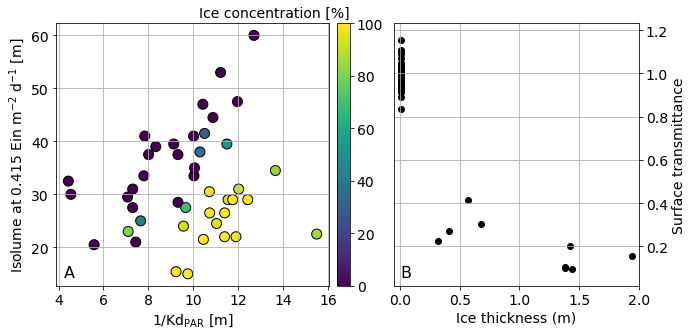

In [21]:
par = pd.read_pickle('nb_temp/GE2016_PAR.pandas')
par=par.loc[par['Depth']==3]

fig,axs=plt.subplots(2,1,figsize=(10,5))


ax=axs[0]

hc=ax.scatter(1/par['Kd'],par['isolume_0415'],c=par['iceConc'],cmap=plt.get_cmap('viridis'),
              s=100,edgecolor='k')
ax.set_xlabel('1/Kd$_\mathrm{PAR}$ [m]')
ax.set_ylabel('Isolume at 0.415 Ein m$^{-2}$ d$^{-1}$ [m]')
axc=plt.colorbar(hc)
axc.ax.set_title('Ice concentration [%]',loc='right', fontdict={'size':14})
ax.grid()



ax=axs[1]
plt.scatter(par['surfaceTransmittanceDepth'],par['surfaceTransmittance'],c='k')

plt.xlim(-.05,2)
plt.grid()
plt.xlabel('Ice thickness (m)')
plt.ylabel('Surface transmittance')

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

for k,label in enumerate(['A','B']):
    axs[k].text(.05,.05,label,
                transform = axs[k].transAxes,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=16
               )

axs[0].set_position([.1, .2, .38, .73])
axs[1].set_position([.57, .2, .34, .73])
axc.ax.set_position([.49, .2, .1,.73])

for ax in list(axs)+[axc.ax]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

plt.savefig('nb_figures/FIGURE_3.pdf')

In [24]:
out = par[['Kd', 'isolume_0415', 'iceConc', 'surfaceTransmittanceDepth', 'surfaceTransmittance']
         ].rename(columns=dict(Kd='Kd_PAR [1/m]',
                               isolume_0415='Isolume depth at 0.415 Ein/m2/d level [m]',
                               iceConc='Ice concentration [%]',
                               surfaceTransmittanceDepth='Ice thickness (Depth of shallowest C-OPS measurement) [m]',
                               surfaceTransmittance='Surface transmittance [-]'
                              ))

out.to_csv('nb_data/FIGURE_3.csv', index=False)

### Add Total Chlorophyll-a

Vertically integrate total chlorophyll over a few relevant depth layers.

In [25]:
chl=pd.read_excel('data/pigments/GreenEdge-Amundsen-pigments-180131.xlsx')
chl=chl[['Station','Total Chlorophyll a','Depth (m)']]
def str2stn(s):
    s=str(s)
    if len(s)>1:
        try:
            return float(s[1:])
        except:
            pass
chl['Station'] = chl['Station'].apply(str2stn)

# chl=chl.set_index(['Station','Depth (m)'])
chl=chl.merge(pd.DataFrame([[s,k] for s in chl['Station'].unique() for k in np.arange(1,100)],
                       columns=['Station','Depth (m)']),how='outer')
chl=chl.set_index('Depth (m)').groupby('Station')
chl=chl.apply(lambda group: group['Total Chlorophyll a'].interpolate(method='slinear')).reset_index()
# chl.reindex(chl.index.union([(s,k) for s in np.arange(100,750) for k in np.arange(1,1000)])).interpolate('index')



ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp_light.pandas')
ctd = ctd.loc[ctd['Depth']==10]
chl=chl.merge(ctd,on='Station')

from scipy.integrate import trapz

chl = chl.sort_values(by=['Station','Depth (m)']).set_index('Depth (m)')
def integrateChla_0415 (row):
    x=row['Total Chlorophyll a']
    isolume = row['isolume_0415'].iloc[0]
    if not np.isnan(isolume):
        integrationRange = (x.index<=isolume) & (np.invert(np.isnan(x.values)))
        t = np.abs(trapz(y=x.values[integrationRange],x=x.index[integrationRange]))
        return t

def integrateChla_01 (row):
    x=row['Total Chlorophyll a']
    isolume = row['isolume_01'].iloc[0]
    if not np.isnan(isolume):
        integrationRange = (x.index<=isolume) & (np.invert(np.isnan(x.values)))
        t = np.abs(trapz(y=x.values[integrationRange],x=x.index[integrationRange]))
        return t

def integrateChla_m (row, to_m):
    x=row['Total Chlorophyll a']
    integrationRange = (x.index<=to_m) & (np.invert(np.isnan(x.values)))
    t = np.abs(trapz(y=x.values[integrationRange],x=x.index[integrationRange]))
    return t

def integrateChla_hBD (row):
    x=row['Total Chlorophyll a']
    hBD = row['hBD'].iloc[0]
    if not np.isnan(hBD):
        integrationRange = (x.index<=hBD) & (np.invert(np.isnan(x.values)))
        t = np.abs(trapz(y=x.values[integrationRange],x=x.index[integrationRange]))
        return t
    
def integrateChla_mld (row):
    x=row['Total Chlorophyll a']
    mld = row['Depth_mixedLayer'].iloc[0]
    if not np.isnan(mld):
        integrationRange = (x.index<=mld) & (np.invert(np.isnan(x.values)))
        t = np.abs(trapz(y=x.values[integrationRange],x=x.index[integrationRange]))
        return t

    
tchl_0415 = chl[['Total Chlorophyll a','isolume_0415']].groupby(chl['Station']).apply(integrateChla_0415)
tchl_01 = chl[['Total Chlorophyll a','isolume_01']].groupby(chl['Station']).apply(integrateChla_01)
tchl_m80 = chl[['Total Chlorophyll a']].groupby(chl['Station']).apply(lambda g: integrateChla_m(g, 80.))
tchl_m30 = chl[['Total Chlorophyll a']].groupby(chl['Station']).apply(lambda g: integrateChla_m(g, 30.))
tchl_hBD = chl[['Total Chlorophyll a','hBD']].groupby(chl['Station']).apply(integrateChla_hBD)
tchl_mld = chl[['Total Chlorophyll a','Depth_mixedLayer']].groupby(chl['Station']).apply(integrateChla_mld)

ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp_light.pandas')

ctd=ctd.set_index('Depth')

chlMax = ctd[['FLOR_01','Depth_chlaMax']].groupby(
    ctd['Station']).apply(lambda group: np.interp(x=group['Depth_chlaMax'].iloc[0],
                                                  xp=group.index,
                                                  fp=group['FLOR_01'].values))
chlSfc = ctd[['FLOR_01','Depth_chlaMax']].groupby(
    ctd['Station']).apply(lambda group: np.interp(x=2,
                                                  xp=group.index,
                                                  fp=group['FLOR_01'].values))

ctd = ctd.reset_index().set_index('Station').merge(
    pd.DataFrame(dict(
        TChla_vertIntegral_0415=tchl_0415,
        TChla_vertIntegral_01=tchl_01,
        TChla_vertIntegral_m80=tchl_m80,
        TChla_vertIntegral_m30=tchl_m30,
        TChla_vertIntegral_hBD=tchl_hBD,
        TChla_vertIntegral_mld=tchl_mld,
        Chla_chlaMax=chlMax,
        Chla_sfc=chlSfc
    )),
    on='Station',how='outer')


ctd.reset_index().to_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp_light_tchla.pandas')
chl.to_pickle('nb_temp/GE2016_total_chlorophyll.pandas')

# Maps

## Overview map

Atlantic and Arctic currents were added later in an external program.

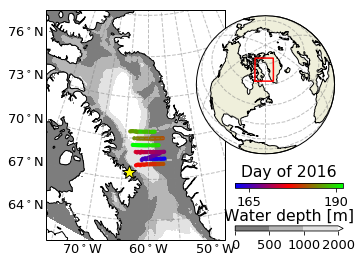

In [26]:
fig = plt.subplots()[0]

proj = ccrs.LambertConformal(central_longitude=-60, central_latitude=70,standard_parallels=(65,75))

def latlon2xy(lon,lat):
    xyz = proj.transform_points(ccrs.PlateCarree(),lon,lat).squeeze()
    x,y,_ = np.split(xyz,3,axis=len(xyz.shape)-1)
    x[np.isinf(x)]=np.nan
    y[np.isinf(y)]=np.nan
    return x.squeeze(),y.squeeze()

ax = plt.axes(projection = proj)
hc=ax.coastlines(resolution='50m')

MapExtent = [-76,-48,62,79]
ax.set_extent(MapExtent, ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.xlocator = mticker.FixedLocator([-80,-75,-70,-65,-60,-55,-50,-45,-40,-35])
gl.ylocator = mticker.FixedLocator(np.arange(58,84,3))

# ICE CAMP
xIceCamp,yIceCamp = latlon2xy(np.array([-63.78953333]),np.array([67.47973333]))
ax.plot(xIceCamp,yIceCamp,'*',markeredgecolor='k',markerfacecolor='yellow',markersize=15)
    
# LONGITUDE LABELS
y0,_ = ax.get_ylim()
for lon in [-70,-60,-50]:
    x0,_ = proj.transform_point(lon,MapExtent[2]-1,src_crs = ccrs.PlateCarree())
    plt.text(x0,y0-2e4,'{:2d}$^\circ$W'.format(-lon),horizontalalignment = 'center',verticalalignment='top')

# LATITUDE LABELS
x0,_ = ax.get_xlim()
someLons = np.arange(-90,-40,1)
for lat in np.arange(64,78,3):
    # interpolate latitude circle to map boundary
    xyzArray = proj.transform_points(ccrs.PlateCarree(),
                                someLons,lat*np.ones_like(someLons))
    x = xyzArray[:,0]
    y = xyzArray[:,1]
    y0 = np.interp(x0,x,y)
    plt.text(x0-2e4,y0,'{:2d}$^\circ$N'.format(lat),horizontalalignment = 'right',verticalalignment='center')



cmap = plt.cm.get_cmap('Greys')
cmap = cmap.from_list('Custom cmap', [cmap(i) for i in range(150,50,-1)], 100)
cmap.set_over('white')
bounds = [0,500,1000,2000]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# load IBCAO bathymetry
top = loadmat('data/IBCAO/IBCAO_1min_bathy.mat')
lon,lat=np.meshgrid(top['x'],top['y'])
z=-top['IBCAO_1min']
hb2=ax.contourf(*latlon2xy(lon,lat),z,levels=[0,500,1000,2000],
                cmap=cmap,norm=norm,extend='max')                      
axcb2= fig.colorbar(hb2,ax=ax,orientation='horizontal')
axcb2.ax.set_title('Water depth [m]')

import pandas as pd
ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc.pandas')
ctd=ctd.groupby('Station').mean()
hb=ax.scatter(*latlon2xy(np.array(ctd['Longitude']),np.array(ctd['Latitude'])),
              c=ctd['DayOfTheYear']-2016000,s=10,
             cmap=plt.cm.get_cmap('brg'))
axcb= fig.colorbar(hb,ax=ax,orientation='horizontal')
axcb.ax.set_title('Day of 2016')
axcb.set_ticks([165,190])

proj2 = ccrs.NearsidePerspective(central_longitude=-60, central_latitude=60)
ax2 = fig.add_subplot(122,projection = proj2)
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')


gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
   
ax3,_,_=map_blueprint(False,False)
extentStudyarea = ax.get_extent()

vertices = np.array([
    [extentStudyarea[0], extentStudyarea[2]], # left, bottom
    [extentStudyarea[0], extentStudyarea[3]], # left, top
    [extentStudyarea[1], extentStudyarea[3]], # right, top
    [extentStudyarea[1], extentStudyarea[2]], # right, bottom
    [extentStudyarea[0], extentStudyarea[2]]
    ])
xVert,yVert = vertices.transpose()
xBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),xVert)
yBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),yVert)

xyzBoxLatlon = ccrs.PlateCarree().transform_points(ax.projection,xBox,yBox)

xBoxLatlon = xyzBoxLatlon[:,0]
yBoxLatlon = xyzBoxLatlon[:,1]

xyzBoxTransformed = proj2.transform_points(ccrs.PlateCarree(),xBoxLatlon,yBoxLatlon)
xBoxTransformed = xyzBoxTransformed[:,0]
yBoxTransformed = xyzBoxTransformed[:,1]
ax2.plot(xBoxTransformed,yBoxTransformed,'r')

ax2.relim()
ax2.autoscale_view()

ax.set_position([.1,.1,.5,.8])
ax2.set_position([.4,.4,.5,.48])
axcb.ax.set_position([.58,.2,.25,.1])
axcb2.ax.set_position([.58,.05,.25,.1])

plt.savefig('nb_figures/FIGURE_1.png',dpi=200)

## Ice cover during campaign

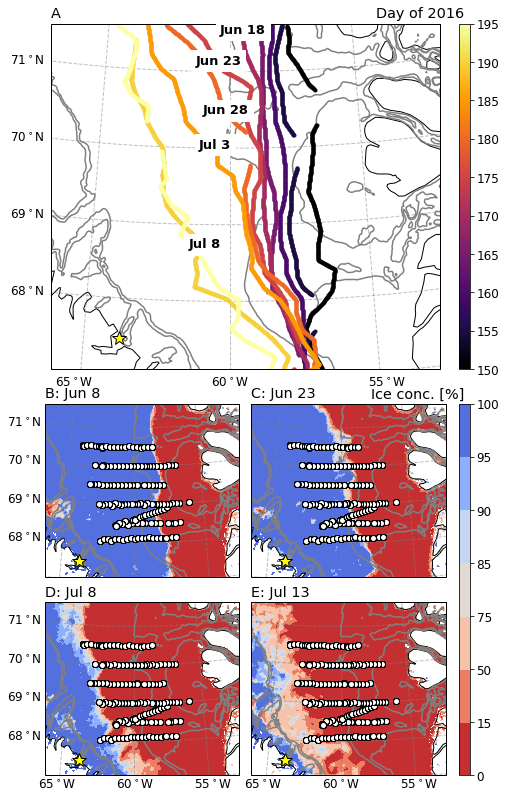

In [27]:
mpl.rc('font', **{'size' : 12})

fig=plt.figure(figsize=(7,12))

# --- ice Edges
ax0,latlon2xy,_=map_blueprint(plotbathymetry=True,fig=fig,label=99,
                             plotxlabels=True)

iceEdges = np.load('nb_temp/GE2016_Amundsen_iceedge_contours_latlon.npy'
        ).item()

allDoys = range(150,201,5)

values = np.arange(150,196,5)
norm  = colors.Normalize(vmin=values[0], vmax=values[-1])
cmap = cm = plt.get_cmap('inferno') 
scalarMap = cmx.ScalarMappable(norm=norm, cmap=cmap)

# plot ice edges
for k,thisDoy in enumerate(values):
    C = iceEdges[thisDoy]
    colorVal = scalarMap.to_rgba(thisDoy)    
    x,y=latlon2xy(C[:,0],C[:,1])
    ax0.plot(x,y,'.',color=colorVal)

ax = fig.add_axes([0.85, 0.125, 0.02, 0.75])   
cbar = mpl.colorbar.ColorbarBase(ax=ax,cmap=cmap,norm=norm,orientation='vertical')
cbar.ax.set_title('Day of 2016',horizontalalignment='right')


# plots annotation labels on ice edge contours
allLats = [71.5,71.1,70.45,70,68.7]
for k,thisDoy in enumerate(np.arange(170,195,5)):
    lat=allLats[k]
    C=iceEdges[thisDoy]
    lon=np.interp(lat,C[:,1],C[:,0])
    x,y=ax0.projection.transform_point(lon,lat,ccrs.PlateCarree())
    thisDate = dt.datetime(2016,1,1)+dt.timedelta(days=int(thisDoy-1))
    timestamp = pd.Timestamp(thisDate)
    thisDateStr = '{} {}'.format(timestamp.month_name()[:3], timestamp.day)
    ax0.text(x,y,'{}'.format(thisDateStr),horizontalalignment='center',
            fontweight='bold',fontsize=13,backgroundcolor='w')
    
ax0.set_title('A',loc='left')

# --- ice conc.

# figure layout params
x1=.07
x2=.48
y2=.05
y1=.28
w=.4
h=.20
pos=[   [x1,y1],
        [x2,y1],
        [x1,y2],
        [x2,y2]
    ]

datadir = 'data/AMSR2/'

latlonFile = datadir + 'LongitudeLatitudeGrid_3.125km_Arctic.nc'
latlonNetcdf = nc.Dataset(latlonFile)
latIce = latlonNetcdf.variables['latitude'][:]
lonIce = latlonNetcdf.variables['longitude'][:]
xIce,yIce=latlon2xy(lonIce,latIce)
maskLand = nc.Dataset(datadir+'Arc_20160714_res3.125_pyres.nc','r').variables['land'][:]

cmap = plt.get_cmap('coolwarm')
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap',[cmap(i) for i in range(cmap.N-1,-1,-1)],cmap.N)

allDoys = [160,175,190,195]
axs=np.empty_like(allDoys).astype('object')
for k,thisDoy in enumerate(allDoys):
    axs[k],_,_=map_blueprint(plotbathymetry=True,plotstations=True,
                             fig=fig,label=k,
                            plotxlabels = pos[k][1]<.1,
                            plotylabels = pos[k][0]<.1)
    thisDate = dt.datetime(2016,1,1)+dt.timedelta(days=int(thisDoy-1))
    timestamp = pd.Timestamp(thisDate)
    thisDateStr = '{} {}'.format(timestamp.month_name()[:3], timestamp.day)
    ax=axs[k]  
    filenameIce = 'Arc_{:04d}{:02d}{:02d}_res3.125_pyres.nc'.format(thisDate.year,thisDate.month,thisDate.day)
    iceConc = nc.Dataset(datadir+filenameIce,'r').variables['sea_ice_concentration'][:].squeeze()#[sliceIce]
    iceConc=np.where(maskLand,iceConc,np.nan)

    hc=ax.contourf(xIce,yIce,iceConc, 
                   cmap=cmap,norm=MidpointNormalize(midpoint=85),
                  levels=[0,15,50,75,85,90,95,100])
    panelLabels = ['B','C','D','E']
    ax.set_title(panelLabels[k]+': {}'.format(thisDateStr),loc='left')
    ax.set_position(pos[k]+[w,h])
    
# 
bblr=axs[3].get_position().extents
bbur=axs[1].get_position().extents
bbll=axs[2].get_position().extents

# ice conc. colorbar
cb_ax = fig.add_axes([.1,.1,.1,.1],label='cb%i'%k) 
axb = mpl.colorbar.Colorbar(ax = cb_ax, mappable = hc ) # use the raw colorbar construct
axb.ax.set_title('Ice conc. [%]',horizontalalignment='right')
axb.ax.set_position([bblr[2]+.02,bblr[1],0.02, bbur[3]-bblr[1]])

# ice edge axes position
ax0.set_position([bbll[0],.52,bblr[2]-bbll[0],.4])
bb0=ax0.get_position().extents
cbar.ax.set_position([bb0[2]+.02,bb0[1],0.02, bb0[3]-bb0[1]])

plt.savefig('nb_figures/FIGURE_2.png',dpi=200)
plt.savefig('nb_figures/FIGURE_2.pdf')

# Results and Discussion part 1; Large-scale hydrography

## T-S plots

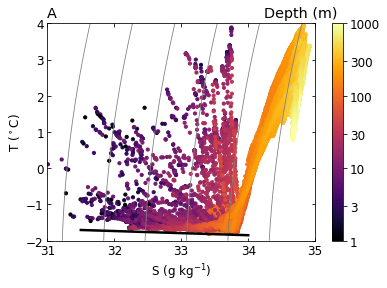

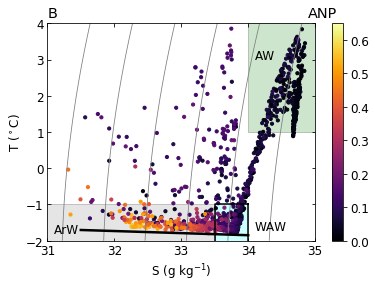

In [28]:
Sgrid = np.linspace(31,35,80)
Tgrid = np.linspace(-2,4,100)
dens = gsw.sigma0(*np.meshgrid(Sgrid,Tgrid))

Sf = np.linspace(31.5,34,10)
Tf = gsw.CT_freezing(Sf,0,0)

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

fnames = []
varnames = ['Depth','ANP']
for k,var in enumerate(varnames):
    if k>=2:
        ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc.pandas')
        s=1
    else:
        ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts.pandas')
        s=10
    fig,ax=plt.subplots()
    if var=='ANP':
        # AW
        ax.add_patch(Polygon(np.c_[[34,34,36,36],[5,1,1,5]], 
                             closed=True, fill=True, facecolor='green',edgecolor='k',
                             zorder=0, alpha=0.2))
        ax.text(34.1,3,'AW',color='k')
        # ArW
        ax.add_patch(Polygon(np.c_[[20,33.5,33.5,20],[-1,-1,-3,-3]], 
                             closed=True, fill=True, facecolor='grey',edgecolor='k',
                             zorder=1e-3, alpha=0.2))
        ax.text(31.1,-1.8,'ArW',color='k')
        # WAW
        ax.add_patch(Polygon(np.c_[[34,33.5,33.5,34],[-1,-1,-3,-3]], 
                     closed=True, fill=True, facecolor='cyan',edgecolor='k',
                             zorder=1e-3, alpha=0.2))
        ax.text(34.1,-1.7,'WAW',color='k')
        ax.plot([34,33.5,33.5,34,34],[-1,-1,-3,-3,-1],'k')
    
    if var=='Depth':
        kwargs={'norm':colors.LogNorm()}
    elif var=='ANP':
        kwargs=dict(vmin=0,vmax=.65)
    else:
        kwargs={}
    
    ax.contour(Sgrid,Tgrid,dens,levels=np.arange(24,28,.5),colors='gray',linewidths=.8)
    ax.plot(Sf,Tf,'k',linewidth=2.5)
    hb=ax.scatter(ctd['Asal'],ctd['Cont'],
                c=ctd[var],
                s=s,cmap=plt.get_cmap('inferno'),**kwargs)
    b=plt.colorbar(hb)
    ax.set_xlabel(r'S (g kg$^{-1}$)')
    ax.set_ylabel(r'T ($^\circ$C)')
    ax.set_xlim(31,35)
    ax.set_ylim(-2,4)
    if var=='Depth':
        b.ax.set_title('Depth (m)',horizontalalignment='right')
        ticks=[1,3,10,30,100,300,1000]
        b.set_ticks(ticks)
        b.set_ticklabels(ticks)
    elif var=='Longitude':
        b.ax.set_title('Longitude ($^\circ$W)',horizontalalignment='right')
    else:
        b.ax.set_title(var,horizontalalignment='right')
        
    if var=='Depth':
        ax.set_title('A',loc='left')
    if var=='ANP':
        ax.set_title('B',loc='left')
    
    ax.tick_params(top=True, right=True, direction='in')
    plt.savefig('nb_figures/FIGURE_6_{:s}.pdf'.format(var))
    f = 'nb_figures/FIGURE_6_{:s}.png'.format(var)
    plt.savefig(f,dpi=300)
    fnames.append(f)

## Maps of hydrographic properties

Enter ice camp data - see Oziel et al., 2018

In [29]:
xIceCamp,yIceCamp = latlon2xy(np.array([-63.78953333]),np.array([67.47973333]))

icecamp = pd.DataFrame(dict(
        x=xIceCamp,
        y=yIceCamp,
        Latitude=67.47973333,
        Longitude=360-63.78953333,
        ANP=0.6,
        Depth_tempMin=40.7,
        Asal_tempMin=32.5,
        isohaline = 154
    ),index=[0])

icecamp

,x,y,Latitude,Longitude,ANP,Depth_tempMin,Asal_tempMin,isohaline
0,-161486.756524,-275132.780295,67.479733,296.210467,0.6,40.7,32.5,154


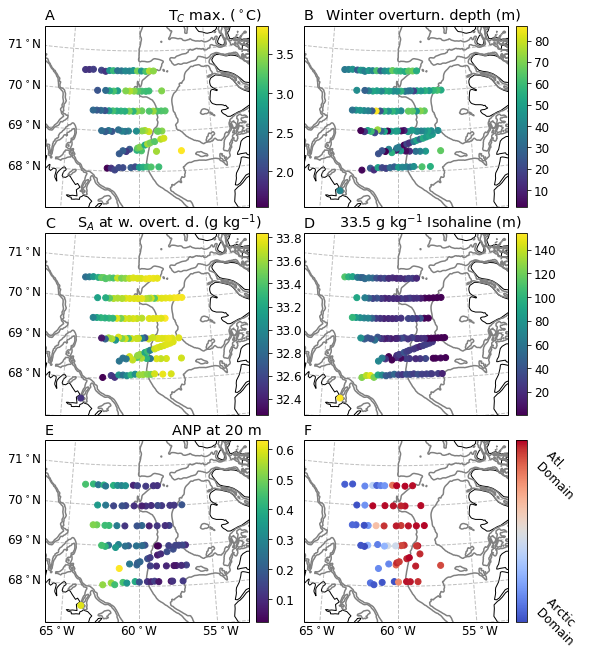

In [30]:
ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered.pandas')

ctd=ctd.loc[ctd['Depth']==20]

fig=plt.figure(figsize=(8,9))

# add ice camp data
ctd = ctd.merge(icecamp,how='outer')
x,y = latlon2xy(np.array(ctd['Longitude']),np.array(ctd['Latitude']))

x1=.02
x2=.47
y3,y2,y1 = 0.03,0.35,0.67
w=.46
h=.28
pos=[[x1,y1],
    [x2,y1],
    [x1,y2],
    [x2,y2],
    [x1,y3],
    [x2,y3]
    ]

panelLabels = ['A','B','C','D','E','F']
varnames = ['Cont_tempMax','Depth_tempMin','Asal_tempMin',
            'isohaline','ANP','cluster']
fullnames = ['T$_C$ max. ($^\circ$C)','Winter overturn. depth (m)','S$_A$ at w. overt. d. (g kg$^{-1}$)',
             '33.5 g kg$^{-1}$ Isohaline (m)','ANP at 20 m','']
axs=np.empty_like(varnames).astype('object')
for k,var in enumerate(varnames):
    axs[k],_,_=map_blueprint(plotbathymetry=True,fig=fig,label=k,
                            plotxlabels = pos[k][1]<.3,
                            plotylabels = pos[k][0]<.3,
                            icecampmarker=False)
    
    ax=axs[k]
    if k==len(varnames)-1:
        cmap = plt.cm.get_cmap('coolwarm')
    else:
        cmap=plt.get_cmap('viridis')
    hc = ax.scatter(x,y,c=ctd[var],cmap=cmap,zorder=1e5)

    #     
    ax.set_title(panelLabels[k],loc='left')
    
    ax.set_position(pos[k]+[w,h])

    # colorbar
    cb_ax = fig.add_axes([.1,.1,.1,.1],label='cb%i'%k) 
    axb = mpl.colorbar.Colorbar(ax = cb_ax, mappable = hc ) # use the raw colorbar constructor
    if k==len(varnames)-1:
        axb.set_ticks([.1,.9])
        axb.set_ticklabels([' Arctic\n Domain',' Atl.\n Domain'])
        axb.ax.tick_params(length=0.,rotation=-45)
        
    axb.ax.set_title(fullnames[k],horizontalalignment='right')
    bb=ax.get_position().extents
    axb.ax.set_position([bb[2]-0.04,bb[1],0.02, bb[3]-bb[1]])
    del ax
    
plt.savefig('nb_figures/FIGURE_8.pdf')

### Transects

#### Nice plot for paper

Mean Latitude:
68.09933471679688


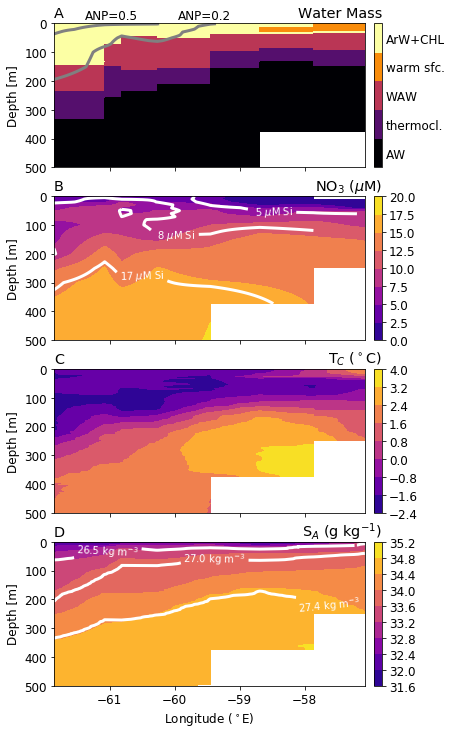

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

transect=4
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered.pandas')
ctd=ctd.loc[(ctd['transect']==transect)&(ctd['Depth_sampledDepthMax']>150)]
print('Mean Latitude:')
print(ctd['Latitude'].mean())

ctd=ctd.set_index(['Longitude', 'Depth']).to_xarray()
ctd=ctd.dropna(dim='Longitude',how='any',subset=['ANP'],thresh=200)

ctd=ctd.interpolate_na(dim='Longitude')

fig,axs=plt.subplots(4,1,sharex=True,sharey=True,figsize=(6,10))

# extract labels to label the ANP contours
def get_contour(contourCollection):
    paths = []
    # for each separate section of the contour line
    for pp in contourCollection.get_paths():
        xy = []
        for vv in pp.iter_segments():
            xy.append(vv[0])
        paths.append(np.vstack(xy))
    return np.vstack(paths)


fullvars=['Water Mass','NO$_3$ ($\mu$M)','T$_C$ ($^\circ$C)','S$_A$ (g kg$^{-1}$)']
vars=['waterMass','NO3','Cont','Asal']
cbs=np.empty_like(axs).astype('object')
for k,var in zip(range(len(vars)),vars):
    if k==0:
        cmap = plt.get_cmap('inferno')
        kwargs={
            'cmap' : cmap,
            'norm' : mpl.colors.BoundaryNorm(np.arange(-.5,5), cmap.N)
        }
        
        hm = axs[k].pcolor(ctd['Longitude'],ctd['Depth'],ctd[var].T,**kwargs)
        
        # ANP + labels
        ANPcont = axs[k].contour(ctd['Longitude'],ctd['Depth'],ctd['ANP'].T,levels=[.2,.5],
                        colors='grey',linewidths=3)
        for i in [0,1]:
            x,y=get_contour(ANPcont.collections[i]).T
            # t.collections[0]
            axs[k].text(x[np.argmin(np.abs(y-4))],-5,'ANP={:2.1f}'.format(ANPcont.levels[i]),
                   horizontalalignment='center',verticalalignment='bottom')
    else:
        kwargs={'cmap':'plasma'}
        
        hm = axs[k].contourf(ctd['Longitude'],ctd['Depth'],ctd[var].T,**kwargs)
    #     hm = axs[k].imshow(ctd[var].T,**kwargs)

    # SIGTH contours
    if k==3:
        cont = axs[k].contour(ctd['Longitude'],ctd['Depth'],ctd['SIGP_01'].T,levels=[26.5,27.,27.4],
                colors='w',linewidths=3)
        plt.clabel(cont, inline=1, fontsize=10,fmt='%2.1f kg m$^{-3}$')
        
    if k==1:
        manloc = [(-58.5,50.),(-60,150),(-60.5,300)]
        cont = axs[k].contour(ctd['Longitude'],ctd['Depth'],ctd['Si'].T,levels=[5.,8.,17.],
                colors='w',linewidths=3)
        plt.clabel(cont, inline=1, fontsize=10,fmt='%2.0f $\mu$M Si',
                  manual=manloc)
        
    cb_ax = fig.add_axes([.1,.1,.1,.1],label='cb%i'%k) 
    cbs[k] = mpl.colorbar.Colorbar(ax = cb_ax, mappable = hm ) # use the raw colorbar constructor
    axs[k].set_ylabel('Depth [m]')
    cbs[k].ax.set_title(fullvars[k],loc='right')
    panelLabels=['A','B','C','D']
    axs[k].set_title(panelLabels[k],loc='left')
    
    
cbs[0].set_ticks([0,1,2,3,4])
cbs[0].set_ticklabels(['AW','thermocl.','WAW','warm sfc.','ArW+CHL'])

cbs[0].ax.tick_params(length=0.,rotation=0)

ax=axs[-1]
ax.set_ylim(0,500)
ax.invert_yaxis()
ax.set_xlabel(r'Longitude ($^\circ$E)')
# for k in range(1,len(axs)):
# axs[0].set_xticklabels('')
    
    
x0,w,h=0.11,0.72,0.2
y0s=0.05+np.linspace(1-h-.08,0,len(axs))
for ax,cb,y0 in zip(axs,cbs,y0s):
    ax.set_position([x0,y0,w,h])
    bb=ax.get_position().extents
    cb.ax.set_position([bb[2]+.02,bb[1],0.02, bb[3]-bb[1]])
    
plt.savefig('nb_figures/FIGURE_7.pdf')

# Results and Discussion part 2; Surface Layer Dynamics
The discussion heavily relies on all transects being averaged as function of OWD, then presented in combined OWD/distance from ice edge coordinates. This is the main plot of the paper:

## Ice edge retreat: Space for time

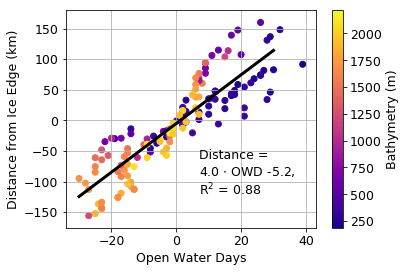

In [26]:
mpl.rc('font', **{'size' : 12.5})

ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc.pandas')
a=ctd.groupby('Station').mean()

fig,ax=plt.subplots()
fig.subplots_adjust(left=.175)
slope, intercept, r_value, p_value, std_err = stats.linregress(a['IRD'],a['distanceFromIceEdge'])
ird = np.array([-30.,30.])
dist = ird*slope+intercept
plt.plot(ird,dist,'k',lw=3)
hb=ax.scatter(a['IRD'],a['distanceFromIceEdge'],c=a['Bot. Depth'],cmap=plt.get_cmap('plasma'))
hcb=plt.colorbar(hb)
hcb.ax.set_ylabel('Bathymetry (m)')
plt.grid()
ax.set_ylabel('Distance from Ice Edge (km)')
ax.set_xlabel('Open Water Days')
plt.text(7,-120,'Distance =\n{:2.1f} $\cdot$ OWD {:+3.1f},\nR$^2$ = {:2.2f}'.format(slope,intercept,r_value))

plt.savefig('nb_figures/FIGURE_5.pdf')
df = a[['IRD', 'distanceFromIceEdge', 'Bot. Depth']]
df.rename(columns={'IRD':'OWD', 'distanceFromIceEdge':'Distance_from_ice_edge_km', 'Bot. Depth': 'Btm_depth_m'}
         ).to_csv('nb_data/FIGURE_5.csv')

## Main cross-ice-edge plot for paper

This plot is a perfect example of the expressiveness, but fairly ugly coding that Matplotlib is so conducive of.

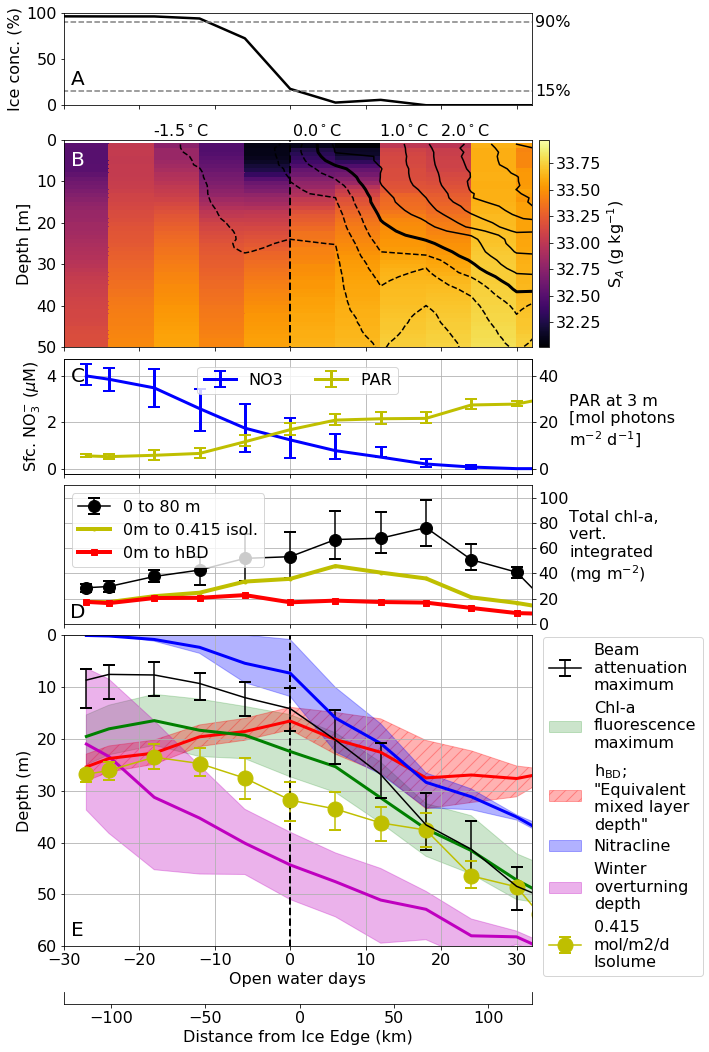

In [33]:
mpl.rc('font', **{'size' : 16})

# --- SALINITY/TEMPERATURE depth x OWD field.
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp_light.pandas')
binvar,step = 'IRD',6

minBin = ctd[binvar].min()
maxBin = ctd[binvar].max()

bins = np.arange(np.floor(minBin/step)*step-0.5*step,np.ceil(maxBin/step)*step,step)
ctd[binvar]=pd.cut(ctd[binvar
              ],bins,
           labels=bins[:-1]+0.5*step).astype('float')
a=ctd.groupby([binvar,'Depth']).mean()
a=a.loc[a.index.get_level_values(1)<100]
xx=a.to_xarray()

# --- AVERAGE VERTICAL LAYERING
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp_light_tchla.pandas')

ctd=ctd.groupby('Station').mean()

ctd[binvar]=pd.cut(ctd[binvar
              ],bins,
           labels=bins[:-1]+0.5*step).astype('float')

aMax=ctd.groupby([binvar]).quantile(.75).reset_index().rolling(3,center=True,min_periods=1).mean()
aMin=ctd.groupby([binvar]).quantile(.25).reset_index().rolling(3,center=True,min_periods=1).mean()
aMean=ctd.groupby([binvar]).mean().reset_index().rolling(3,center=True,min_periods=2).mean()



x=np.r_[aMax[binvar],aMin[binvar][::-1]]
patches=[]
#
var='Depth_chlaMax'
y=np.r_[aMax[var],aMin[var][::-1]]
patches.append(Polygon(np.c_[x,y], closed=True, color='g',alpha=0.2))
#
var='hBD'
y=np.r_[aMax[var],aMin[var][::-1]]
patches.append(Polygon(np.c_[x,y], closed=True, color='r',alpha=.3, hatch='//'))
#
var='Nitracline'
y=np.r_[aMax[var],aMin[var][::-1]]
patches.append(Polygon(np.c_[x,y], closed=True, color='b',alpha=0.3, hatch=''))
#
var='Depth_tempMin'
y=np.r_[aMax[var],aMin[var][::-1]]
patches.append(Polygon(np.c_[x,y], closed=True, color='m',alpha=0.3, hatch=''))

fig,axs=plt.subplots(6,1,sharex=False,figsize=(10, 16))


# --- PANEL B: HYDROGRAPHY

ax=axs[1]
ax.grid()
ax.plot([0,0],[100,0],'k--',lw=2)
ax.set_ylim(0,50)
ax.invert_yaxis()
ax.set_ylabel('Depth [m]')
ax.set_xlim(-30,32)
ax.set_xticklabels([])

hb=ax.pcolor(*np.meshgrid(xx[binvar],xx['Depth']),xx['Asal'].T,
             cmap=plt.get_cmap('inferno'))
hcb=fig.colorbar(hb,ax=ax)
hcb.ax.set_ylabel('S$_A$ (g kg$^{-1}$)')
tempCont=ax.contour(*np.meshgrid(xx[binvar],xx['Depth']),
              xx['Cont'].T,levels=np.arange(-2,6,.5),colors='k')
ax.contour(*np.meshgrid(xx[binvar],xx['Depth']),
              xx['Cont'].T,levels=[0],
           colors='k',linewidths=3)

# labels:
def get_contour(contourCollection):
    paths = []
    # for each separate section of the contour line
    for pp in contourCollection.get_paths():
        xy = []
        for vv in pp.iter_segments():
            xy.append(vv[0])
        paths.append(np.vstack(xy))
    return np.vstack(paths)
for i in [0,3,5,7]:
    x,y=get_contour(tempCont.collections[i]).T
    ax.text(x[np.argmin(y)],-1,'{:2.1f}$^\circ$C'.format(tempCont.levels[i]),
           horizontalalignment='center')
plt.text(0.03,0.9,'B',
         horizontalalignment = 'center',verticalalignment='center',
        transform=ax.transAxes, fontsize=20,
        color='w')
    
# --- VERTICAL LAYERS
ax=axs[2]
ax.grid()
# some visual guides
ax.plot([0,0],[100,0],'k--',lw=2)
ax.set_ylim(0,60)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Open water days')
ax.set_xlim(axs[1].get_xlim())

for k in range(len(patches)):
    ax.add_patch(patches[k])
    
ax.plot(aMean[binvar],aMean['Depth_tempMin'],'m-',lw=3)
ax.plot(aMean[binvar],aMean['hBD'],'r-',lw=3)
ax.plot(aMean[binvar],aMean['Nitracline'],'b-',lw=3)
ax.plot(aMean[binvar],aMean['Depth_chlaMax'],'g-',lw=3)

hIsol = ax.errorbar(x=aMean['IRD'],y=aMean['isolume_0415'],
            yerr=[aMax['isolume_0415']-aMean['isolume_0415'], aMean['isolume_0415']-aMin['isolume_0415']],
            fmt='yo-',capsize=6,capthick=2,markersize=15)

# hB = ax.plot(aMean[binvar],aMean['Depth_beamattMax'],'k-',lw=4)
hB = ax.errorbar(x=aMean[binvar],y=aMean['Depth_beamattMax'],
            yerr=[aMax['Depth_beamattMax']-aMean['Depth_beamattMax'], 
                  aMean['Depth_beamattMax']-aMin['Depth_beamattMax']],
            fmt='k-',capsize=6,capthick=2,markersize=15)

ax.legend([hB]+patches+[hIsol],
          ['Beam\nattenuation\nmaximum',
           'Chl-a\nfluorescence\nmaximum',
           'h$_\mathrm{BD}$;\n"Equivalent\nmixed layer\ndepth"',
           'Nitracline',
           'Winter\noverturning\ndepth',
           '0.415\nmol/m2/d\nIsolume',
           ],
          bbox_to_anchor=(1.02,1), 
          #loc=2, 
          borderaxespad=0.1)
plt.text(0.03,0.05,'E',
         horizontalalignment = 'center',verticalalignment='center',
        transform=ax.transAxes, fontsize=20)

# --- ADDITIONAL IRD->KM X-AXIS
ax=axs[3]
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(4.0*np.array(axs[1].get_xlim())-5.)
ax.set_xlabel('Distance from Ice Edge (km)')

# --- ICE CONCENTRATIONS
ax=axs[0]
ax.plot(xx[binvar],xx['iceConc'][:,0],'k-',lw=2.5)
ax.set_xticklabels([])
ax.plot([-50,50],[15,15],'k--',color='gray')
ax.plot([-50,50],[90,90],'k--',color='gray')
ax.set_ylabel('Ice conc. (%)')
xlims=axs[1].get_xlim()
ax.set_xlim(xlims)
ax.set_ylim(0,100)
# ax.set_yticklabels([0,50,100])
ax.text(xlims[1]+.5,15,'15%',verticalalignment='center')
ax.text(xlims[1]+.5,90,'90%',verticalalignment='center')
plt.text(0.03,0.28,'A',
         horizontalalignment = 'center',verticalalignment='center',
        transform=ax.transAxes, fontsize=20)

# --- sfc NO3 + sfc PAR

ax=axs[5]
vname = 'NO3_sfc'
h1 = ax.errorbar(x=aMean[binvar], y=aMean[vname], 
                 yerr = [np.abs(aMax[vname] - aMean[vname]),
                         aMean[vname] - aMin[vname]],
                 fmt='-',color='blue',capsize=6,capthick=2,markersize=12, 
                 linewidth=3)
ax.grid()
ax.set_ylabel('Sfc. NO$_3^{-}$ ($\mu$M)')
ax.set_xticklabels([])
plt.text(0.03,0.85,'C',
         horizontalalignment = 'center',verticalalignment='center',
        transform=ax.transAxes, fontsize=20)

axt = ax.twinx()
# h2 = axt.plot(aMean[binvar], aMean['PAR_3m'], lw=3, c='y')
vname = 'PAR_3m'
h2 = axt.errorbar(x=aMean[binvar], y=aMean[vname], 
                 yerr = [np.abs(aMax[vname] - aMean[vname]),
                         aMean[vname] - aMin[vname]],
                 fmt='-',color='y',capsize=6,capthick=2,markersize=12, 
                 linewidth=3)
axt.set_ylim(*[10*l for l in ax.get_ylim()])
axt.text(37,20,'PAR at 3 m\n[mol photons\nm$^{-2}$ d$^{-1}$]',
        horizontalalignment = 'left',
       verticalalignment = 'center')
ax.legend([h1,h2],['NO3', 'PAR'], loc=9, ncol=2)
ax.set_xlim(xlims)

# --- TOTAL CHLOROPHYLL
ax=axs[4]
ax.set_xticklabels([])
vname = 'TChla_vertIntegral_m80'
hm80 = ax.errorbar(x=aMean[binvar], y=aMean[vname], 
                   yerr=[np.abs(aMax[vname] - aMean[vname]),
                         aMean[vname] - aMin[vname]],
            fmt='o-',color='k',capsize=6,capthick=2,markersize=12)


# ax.plot(ctd['IRD'],ctd['TChla_vertIntegral_m'],'.')
h0415=ax.plot(aMean['IRD'],aMean['TChla_vertIntegral_0415'],color='y',marker='.', lw=4)
hhBD=ax.plot(aMean['IRD'],aMean['TChla_vertIntegral_hBD'],color='r',marker='s', lw=4)

# hcb2=plt.colorbar(hb2)
ax.yaxis.tick_right()
ax.grid()
ax.set_xlim(xlims)
# ax.set_yscale('log')
ax.set_yticks(range(0,101,20))
ax.set_ylim(0,110)
ax.text(37,60,'Total chl-a,\nvert. \nintegrated\n(mg m$^{-2}$)',
        horizontalalignment = 'left',
       verticalalignment = 'center')
ax.legend([hm80]+h0415+hhBD, ['0 to 80 m', '0m to 0.415 isol.', '0m to hBD'],loc=2)

plt.text(0.03,0.08,'D',
         horizontalalignment = 'center',verticalalignment='center',
        transform=ax.transAxes, fontsize=20)


# --- POSITION
axs[0].set_position( [0.12,0.88 ,0.65,.08])

axs[1].set_position( [0.12,0.67 ,0.65,.18])
hcb.ax.set_position( [0.78,0.67 ,0.15,.18])

axs[5].set_position( [0.12,0.56 ,0.65,.1])

axs[4].set_position( [0.12,0.43 ,0.65,.12])


axs[2].set_position( [0.12,0.15 ,0.65,.27 ])

axs[3].set_position( [0.12,0.1  ,0.65,.01])

plt.savefig('nb_figures/FIGURE_9.pdf')

# export
df = aMean[[
    'IRD',
    'hBD','Nitracline','Depth_chlaMax','isolume_01','isolume_0415', 'Depth_tempMin', 
    'PAR_3m', 'NO3_sfc', 
    
    'TChla_vertIntegral_0415', 'TChla_vertIntegral_hBD', 'TChla_vertIntegral_m80',
]]
df.to_csv('nb_data/FIGURE_9-c-d-e.csv', index=False)

ds = xx[['Cont', 'Asal', 'iceConc']].rename(IRD='OWD')
ds.to_netcdf('nb_data/FIGURE_9-a-b.nc')

# Clustering: Produce latex table

In [34]:
ctd=pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered.pandas')
ctd['cluster']=pd.cut(ctd['cluster'],bins=[0,.1,.9,1.],labels=['ArW',.5,'AW'])#.astype('float')

varnames = ['Cont_tempMax','Depth_tempMin','NO3_tempMin','iceConc','Asal_tempMin',
            'isohaline']#,'Depth_mixedLayer']
latexnames =['T$_C$ max. [$^\circ$C]',
             'Depth of T$_\mathrm{min}$ [m]',
            'NO$_3$ at T$_\mathrm{min}$ [$\mu$M]',
            'Ice conc. [\%]',
            'S$_A$ at T$_\mathrm{min}$ [g~kg$^{-1}$]',
            'Depth of 33.5~g~kg$^{-1}$ [m]']
#             'Density Mixed Layer depth [m]']
# ctd=ctd.groupby(['cluster','Depth']).mean().reset_index()
s=ctd.groupby('cluster')[varnames]
s=s.describe()
tab=s.loc[:,(slice(None),'mean')].drop(0.5).round(2).rename_axis('')
tab.columns=tab.columns.droplevel(1)
# # tab.rename=
renamevars=dict(zip(varnames,latexnames))
tab=tab.rename(columns=renamevars,index={'AW':'Atl. domain','ArW':'Arctic domain'})
tab=tab.transpose()
# typeset as latex:
tab.to_latex('nb_temp/TAB_cluster.tex',escape=False)
tab.to_csv('nb_data/TABLE_1.csv', na_rep='NaN')
tab

,Arctic domain,Atl. domain
T$_C$ max. [$^\circ$C],2.11,3.34
Depth of T$_\mathrm{min}$ [m],29.40,42.32
NO$_3$ at T$_\mathrm{min}$ [$\mu$M],6.10,7.13
Ice conc. [\%],74.50,40.42
S$_A$ at T$_\mathrm{min}$ [g~kg$^{-1}$],32.89,33.56
Depth of 33.5~g~kg$^{-1}$ [m],88.27,24.33


# Export data with self-explanatory column names

## Corrected PAR

In [35]:
par=pd.read_pickle('nb_temp/GE2016_PAR.pandas').replace(to_replace=-999, value=np.nan)
print(par.columns)

Index(['Depth', 'iceConc', 'PAR_ratio_ice', 'PAR_ratio_openWater',
       'PAR_ratio_orig_measured', 'surfaceTransmittance',
       'surfaceTransmittanceDepth', 'PAR0', 'Station', 'platform', 'longitude',
       'latitude', 'iceTransmittance', 'PAR_ratio', 'PAR', 'PAR_ice',
       'isolume_0415', 'isolume_0415_ice', 'isolume_01', 'isolume_01_ice',
       'Kd', 'Kd_ice', 'Zeu', 'Zeu_ice', 'hBD', 'PAR_avg_hBD', 'PAR_3m'],
      dtype='object')


In [36]:
par = par[['Station', 'Depth', 'PAR', 'PAR0', 'PAR_ratio_ice', 'PAR_ratio_openWater', 'iceConc', 'platform']]

par = par.rename(columns=dict(
    iceConc='IceConcentration_percent',
    Depth='Depth_m',
    platform = 'Sampled_under_ice_or_in_open_water',
    PAR_ratio_ice='Ratio_of_under_ice_PAR_to_surface_PAR',
    PAR_ratio_openWater='Ratio_of_openwater_PAR_to_surface_PAR',
    PAR = 'PAR_irradiance_Einm2-d1',
    PAR0 = 'PAR0+_Einm2-d1'
))
par.to_csv('nb_data/Randelhoff-et-al_GreenEdge_PAR_corrected_v1.0.csv', na_rep='NaN')

par.head()

,Station,Depth_m,PAR_irradiance_Einm2-d1,PAR0+_Einm2-d1,Ratio_of_under_ice_PAR_to_surface_PAR,Ratio_of_openwater_PAR_to_surface_PAR,IceConcentration_percent,Sampled_under_ice_or_in_open_water
0,100.0,0.00,NaN,37.941264,NaN,NaN,0.0,OW
1,100.0,0.01,39.370570,37.941264,NaN,1.037672,0.0,OW
2,100.0,0.02,39.255452,37.941264,NaN,1.034637,0.0,OW
3,100.0,0.03,39.140987,37.941264,NaN,1.031621,0.0,OW
4,100.0,0.04,39.027169,37.941264,NaN,1.028621,0.0,OW


## Vertically resolved variables

In [37]:
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp_light_tchla.pandas')

ctd.columns

Index(['Station', 'Depth', 'Asal', 'Bot. Depth', 'Bottle', 'CDOM_01', 'Cast',
       'Cont', 'D0ct', 'DOXY_01', 'D_ct', 'DayOfTheYear', 'FLOR_01', 'FRET_01',
       'Latitude', 'Longitude', 'NH4', 'NO2', 'NO3', 'NTRA_01', 'PO4',
       'POTM_01', 'PRES_01', 'PSAL_01', 'PSAR_01', 'Prof. cast (m)', 'SIGM_01',
       'SIGP_01', 'SIGT_01', 'SPAR_01', 'SPVA_01', 'Si', 'TE90_01', 'TRAN_01',
       'VAIS_01', 'doy', 'hour', 'transect', 'nstar', 'ANP', 'ANP_pw', 'ODS',
       'IDU', 'iceConc', 'distanceFromIceEdge', 'IRD2', 'IRD', 'DeltaT',
       'Cont_tempMin', 'TE90_01_tempMin', 'NO3_tempMin', 'Depth_tempMin',
       'Asal_tempMin', 'nstar_tempMin', 'DeltaT_tempMin',
       'Depth_sampledDepthMax', 'Cont_tempMax', 'TE90_01_tempMax',
       'NO3_tempMax', 'PO4_tempMax', 'nstar_tempMax', 'Depth_tempMax',
       'isohaline', 'SIGP_01_ref', 'DeltaSigth', 'BD', 'hBD',
       'Depth_mixedLayer', 'Nitracline', 'NO3_sfc', 'NO3_chlaMax',
       'Depth_chlaMax', 'FLOR_01_chlaMax', 'beamatt', 'Depth_b

In [38]:
ctd=ctd[['Station', 'Depth', 'ANP', 'Longitude', 'Latitude']].rename(columns=dict(
        Depth = 'Depth_m'
))

ctd.to_csv('nb_data/Randelhoff-et-al-2019_GreenEdge_ANP_v1.0.csv', na_rep='NaN')
ctd.head(3)

,Station,Depth_m,ANP,Longitude,Latitude
0,100.0,2.0,0.139851,-56.792496,68.500053
1,100.0,3.0,0.139851,-56.792496,68.500053
2,100.0,4.0,0.139851,-56.792496,68.500053


## Per-station data (data that require no vertical resolution)

In [39]:
ctd = pd.read_pickle('nb_temp/GE2016_Amundsen_hydrography_data_includes_nuts_ice_1dprop_sfc_clustered_scamp_light_tchla.pandas')

ctd=ctd[['Station','isolume_01','isolume_0415','iceConc',
         'Depth_mixedLayer','hBD','Nitracline','cluster','IRD','PAR_3m']].groupby('Station').first()

ctd = ctd.rename(columns=dict(
    isolume_01='isolume_m_at_0.1_Einm-2d-1',
    isolume_0415='isolume_m_at_0.415_Einm2-d1',
    iceConc='IceConcentration_percent',
    Depth_mixedLayer='MixedLayerDepth_0.1gkg-1-criterion_m',
    hBD = 'hBD_m',
    Nitracline='Nitracline_m',
    cluster='AW-ArW_clustering_coefficient',
    IRD='OWD',
    PAR_3m='PAR_irradiance_at_3m_Einm-2d-1'
))
ctd.to_csv('nb_data/Randelhoff-et-al-2019_GreenEdge_per-station_v1.0.csv', na_rep='NaN')
ctd.head(3)

,isolume_m_at_0.1_Einm-2d-1,isolume_m_at_0.415_Einm2-d1,IceConcentration_percent,MixedLayerDepth_0.1gkg-1-criterion_m,hBD_m,Nitracline_m,AW-ArW_clustering_coefficient,OWD,PAR_irradiance_at_3m_Einm-2d-1
Station,,,,,,,,,
100.0,52.0,39.5,0.0,27.0,28.949984,30.0,NaN,12.0,21.297821
101.0,NaN,NaN,0.0,46.0,40.786690,39.0,0.915202,12.0,NaN
102.0,42.0,31.0,0.0,46.0,40.802655,39.0,NaN,12.0,19.587099
